# Optimisation de la turbine

Chargement de module utile pour la suite

In [1]:
import pandas as pd                      # pour gerer les tableaux de données comme excel
import numpy as np                       # pour les calculs sur des données matricielles
import matplotlib.pyplot as plt          # pour les traces
import matplotlib.ticker as tck          # pour le formateage de labels
from scipy.interpolate import interp1d,UnivariateSpline   # pour l'interpolation du rendement pondere

In [2]:
# chargement du module specifique
import os
import sys
sys.path.insert(0, os.path.abspath('../common'))
# pour la lecture et l'interpolation de la colline donnée
from module_turbine_data import CollineModeleClass, plot_transient

## Constantes physiques

* L'accélération gravitationnelle `g` en m$^2$/s$^2$ donnée par le client.
* La température de l'eau `theta` en °C donnée par le client.

In [3]:
g = 9.8105
theta = 10 # degree celsius

* Le bief aval de l'ìnstallation est à une élévation d'environ 80m. On peut donc supposer la pression atmosphérique à $p_{atm} = 10^5$ Pa à l'aval. La pression absolue en tenant compte de la chute nette énoncée plus tard sera de l'ordre de 6 à 7 bar. 
* La masse volumique de l'eau `rho` est considérée comme constante dans toute la suite. Elle est estimée à l'aide du tableau B.2 de la norme CEI 60193 pour la temperature de 10°C et la pression absolue attendue (par interpolation linéaire entre 999.7 et 1000.1 kg/m$^3$)

In [4]:
p_atm = 1.0e5
rho = 999.7 + (1000.1-999.7)/(10e5-1e5)*(6e5-1.0e5)
print('rho={0:.1f} kg/m3'.format(rho))

rho=999.9 kg/m3


* La pression de vapeur saturante $p_{va}$ de l'eau est calculée selon la formule 2.5.3.4 de la norme CEI  
\begin{align}
p_{va}\left(\theta\right) = 10^{2.7862+0.0312 \theta -0.000104\theta^2}
\end{align}

In [5]:
p_va = 10**(2.7862+0.0312 *theta -0.000104*theta**2)
print('p_va = {0:.3f} Pa (±7 Pa)'.format(p_va))

p_va = 1224.052 Pa (±7 Pa)


* La viscosité cinématique de l'eau $\nu$ est calculée selon la formule 2.5.3.3 de la norme CEI  
\begin{align}
\nu\left(\theta\right) = e^{-16.921+\frac{396.13}{107.41+\theta}}
\end{align}

In [6]:
nu = np.exp(-16.921+396.13/(107.41+theta))
print('nu = {0:.3e} m2/s2'.format(nu))

nu = 1.308e-06 m2/s2


## Données du problème

* Puissance électrique `P_e` en Watt pour une unité
* Rendement de l'alternateur `eta_alt`
* Rendement hydraulique `eta_h`
* Facteur de puissance `P_ED`
* Chutte nominale `H` en mètre

In [7]:
P_e = 150e6
eta_alt = 98.4/100.
P_ED = 0.9
H = 60.0
Hmax = 63.0
Hmin = 50.0 

* Puissance mécanique $P_m$ (notée `P_m`) correspond à la puissance à l'arbre pour l'énergie hydraulique $P_h=\rho g H Q $ disponible. Les rendements électrique (de l'alternateur) $\eta_{alt}$ et hydraulique $\eta_h$ relient les differentes puissances.
\begin{align}
\eta_{alt} &= \frac{P_e}{P_m}\\
\eta_{h} &= \frac{P_m}{P_h}
\end{align}

In [8]:
P_m = P_e / eta_alt
print('P_m = {0:.2f} MW'.format(P_m/1e6))

P_m = 152.44 MW


## Données du turbinier

Chemin vers le fichier excel contenant les donnees turbinier `input_excel_colline` (mis à jour le 27 Mars 2020). Les données correspondent à des données de performances sur un modèle dont le diamètre a été rapporté à 1 m au nombre de Reynolds de $7\times10^6$. Dans la suite, l'indice M correspondra à des données liées au modèle (par distinction aux données du prototype).

In [9]:
input_excel_colline = os.path.abspath('../common/data_project.xlsx')
Re_M = 7.0e6
# on cree une instance de la classe CollineModele qui sera utilisee pour l'interpolation
colline_modele = CollineModeleClass(input_excel_colline,Re_M,convert_to_m3s=True)

### Fonctions d'interpolation

Création des fonction d'interpolation $Q_{11}=f_{Q}\left(\gamma,n_{11}\right)$ et $\eta_{h,M} = f_{\eta}\left(\gamma,n_{11}\right)$.

Système $Q_{11}$, $N_{11}$ respectivement en $m^3/s$ et en rpm.
\begin{align}
Q_{11} & = \frac{Q}{D^2 \sqrt{H}}\\
N_{11} & = \frac{n_{rpm} D}{\sqrt{H}}
\end{align}

In [10]:
colline_modele.interpol_colline(spline_order=2,smoothing=0.01)
colline_modele.interpol_max_colline(spline_order=1)

[0.0, 40.0]
[60.0, 145.0]


## Fonction de calcul du rendement pondere pour des fins d'optimisation

In [11]:
def rendement_pondere(colline_modele,n11,D):
    ponderation = pd.DataFrame({'% P_m': [100,90,82,70,60],'Poids': [10,20,40,20,10]})
    ponderation['Puissance [W]'] = ponderation['% P_m']/100 * P_m

    n_rpm_sync,d_eta_maj_pm,gamma_pc,Q_pc,eta_P_pc,P_mp_pc = colline_modele.prise_charge(
        n11,D,rho,g,H,nu,npts_intp=100,flag_plot=False)
    print('Vitesse synchrone: {0:.2f} rpm'.format(n_rpm_sync))
    if P_mp_pc.max()>P_m: 
        # Intervale restreint pour avoir une fonction bijective
        ipmax =  P_mp_pc.argmax()
        fpe = interp1d(P_mp_pc[:ipmax+1],eta_P_pc[:ipmax+1],kind='cubic')
        # On choisit une spline d'ordre 2
        sple = UnivariateSpline(P_mp_pc[:ipmax+1],eta_P_pc[:ipmax+1],k=2,s=0) 
        ponderation['Eta [-]'] = sple(ponderation['Puissance [W]'])
    else:
        # Penalite sur le rendement si la puissance max n'est pas atteignable
        ponderation['Eta [-]'] = np.zeros(ponderation.shape[0])
    eta_p_weighted = np.sum(ponderation['Eta [-]']*ponderation['Poids'])/100.
    print('Rendement pondéré: {0:.3f} %'.format(eta_p_weighted*100))
    
    gain = (eta_p_weighted-0.935)*100*12e6
    cost_turbine = 22e6*(D/6.)
    
    return gain,cost_turbine,n_rpm_sync,d_eta_maj_pm,ponderation,eta_p_weighted

In [45]:
def geometry_penalty(colline_modele,D,display=False):
    penalty = 0
    proto_geom = colline_modele.scale_proto_geometry(D)
    entraxe = 2+max(proto_geom.iloc[6].Valeur+proto_geom.iloc[5].Valeur/2,proto_geom.iloc[7].Valeur+proto_geom.iloc[5].Valeur/2)/1000
    L_aspi = proto_geom.iloc[4].Valeur/1000
    H_aspi = proto_geom.iloc[9].Valeur/1000
    l_aspi = proto_geom.iloc[5].Valeur/1000
    decentrement = (proto_geom.iloc[6].Valeur - proto_geom.iloc[7].Valeur)/1000
    if (entraxe-20)>1.5 or (entraxe-20)<-0.5:
        if display:
            print('Depassement entraxe: {0:.2f} m '.format(entraxe))
        penalty += 1.0e6*abs(entraxe-20)
    if abs(L_aspi-26)>3:
        if display:
            print('Depassement longueur aspirateur: {0:.2f} m'.format(L_aspi))
        penalty += 1.0e6*abs(L_aspi-26)
    if abs(H_aspi-6.7)>1.5:
        if display:
            print('Depassement hauteur aspirateur: {0:.2f} m'.format(H_aspi))
        penalty += 1.0e6*abs(H_aspi-6.7)
    if abs(l_aspi-19)>1.5:
        if display:
            print('Depassement largeur aspirateur: {0:.2f} m'.format(l_aspi))
        penalty += 1.0e6*abs(l_aspi-19)
    if abs(decentrement-7)>1.5:
        if display:
            print('Depassement decentrement: {0:.2f} m'.format(decentrement))
        penalty += 1.0e6*abs(decentrement-7)
    
    # Clean
    if not display:
        del colline_modele.proto_geom
    
    return penalty

In [13]:
def civil_costs(colline_modele, D,ponderation,z0_lims = [63.15-5,63.15+5],k11_lim = 0.21,Bief_aval = 83.45-0.5):
    colline_modele.scale_proto_geometry(D)
    Q_max_nom = P_m/(rho*g*H*float(ponderation.loc[ponderation['% P_m']==100,'Eta [-]']))
    hs,z0,volume_trou = colline_modele.target_k11(k11_lim,p_atm,Bief_aval,p_va,Q_max_nom,H,rho,g)
    
    if z0<z0_lims[0] or z0>z0_lims[1]:
        # penalite
        cost_civil = volume_trou * 9000
    else: 
        cost_civil = volume_trou * 900
    return cost_civil,hs,z0

In [14]:
def optimize_turbine(colline_modele,n11,method='SLSQP'):
    from scipy.optimize import minimize
    def cost_objective(x):
        D = x[0]
        gain,cost_turbine,n_rpm_sync,d_eta_maj_pm,ponderation,eta_p_weighted = rendement_pondere(colline_modele,n11,D)
        if eta_p_weighted>0.8:
            penalty = geometry_penalty(colline_modele,D)
            cost_civil,hs,z0 = civil_costs(colline_modele, D,ponderation)
            total_cost = abs(cost_turbine + penalty + cost_civil - gain)
        else:
            total_cost = abs(cost_turbine - gain)
        return total_cost
    optim = minimize(cost_objective,[6.0,],tol=1.0e-5,bounds=[(5.0,8.0)],method=method)
    
    gain,cost_turbine,n_rpm_sync,d_eta_maj_pm,ponderation,eta_p_weighted = rendement_pondere(colline_modele,n11,
                                                                                             optim.x[0])
    penalty = geometry_penalty(colline_modele,optim.x[0]);
    cost_civil,hs,z0 = civil_costs(colline_modele,optim.x[0],ponderation);
    
    costs = [cost_turbine,penalty,cost_civil,gain]
    perf = [n_rpm_sync,d_eta_maj_pm,eta_p_weighted,hs,z0]
    return optim.x[0],costs,perf,ponderation

In [21]:
nval = 50
n11_vec = np.linspace(70,85,nval)
results_optim = pd.DataFrame(columns=['n11','D_opt','$ turbine','$ civil','$ malus geometrie','$ bonus performance',
                                     'enfoncement','cote fond aspirateur','rendement cum','n_rpm_sync','majoration_rendement',
                                     '$ optim'])
ponderation_vec = []
for i,n11 in enumerate(n11_vec):
    D_opt,costs,perf,eta_pond = optimize_turbine(colline_modele,n11,method='Nelder-Mead')
    ponderation_vec.append(eta_pond)
    cost_obj = costs[0]+costs[1]+costs[2]- costs[3]
    results_optim.loc[i] = {'n11': n11,'D_opt': D_opt,'$ turbine': costs[0],'$ civil': costs[2],
                            '$ malus geometrie': costs[1],'$ bonus performance': costs[3],
                            'enfoncement': perf[3],'cote fond aspirateur': perf[4],'rendement cum': perf[2],
                            'n_rpm_sync': perf[0],'majoration_rendement': perf[1],'$ optim': cost_obj}

Nombre de poles: 39
eta_M_max = 92.773 %
Re_p = 1.330e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.059 %
Majoration du rendement calculee
d_eta_maj_pm=1.901 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 92.901 %
Nombre de Thomas vise: 0.2344
Hauteur de sustentation necessaire hs=-3.381 m
Altitude du fond aspirateur z0=65.691 m
Nombre de poles: 41
eta_M_max = 92.737 %
Re_p = 1.395e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.084 %
Majoration du rendement calculee
d_eta_maj_pm=1.934 %
Vitesse synchrone: 87.80 rpm
Rendement pondéré: 92.635 %
Nombre de Thomas vise: 0.1682
Hauteur de sustentation necessaire hs=0.416 m
Altitude du fond aspirateur z0=68.794 m
Nombre de poles: 37
eta_M_max = 92.812 %
Re_p = 1.266e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.032 %
Majoration du rendement calculee
d_eta_maj_pm=1.865 %
Vitesse synchrone

Nombre de Thomas vise: 0.1876
Hauteur de sustentation necessaire hs=-0.698 m
Altitude du fond aspirateur z0=67.971 m
Nombre de poles: 41
eta_M_max = 92.066 %
Re_p = 1.341e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.554 %
Majoration du rendement calculee
d_eta_maj_pm=2.091 %
Vitesse synchrone: 87.80 rpm
Rendement pondéré: 92.642 %
Nombre de Thomas vise: 0.1911
Hauteur de sustentation necessaire hs=-0.897 m
Altitude du fond aspirateur z0=67.769 m
Nombre de poles: 41
eta_M_max = 92.066 %
Re_p = 1.341e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.554 %
Majoration du rendement calculee
d_eta_maj_pm=2.091 %
Vitesse synchrone: 87.80 rpm
Rendement pondéré: 92.642 %
Nombre de Thomas vise: 0.1911
Hauteur de sustentation necessaire hs=-0.897 m
Altitude du fond aspirateur z0=67.769 m
Nombre de poles: 40
eta_M_max = 92.868 %
Re_p = 1.373e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Nombre de Thomas vise: 0.1876
Hauteur de sustentation necessaire hs=-0.695 m
Altitude du fond aspirateur z0=67.973 m
Nombre de poles: 40
eta_M_max = 92.872 %
Re_p = 1.374e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.990 %
Majoration du rendement calculee
d_eta_maj_pm=1.891 %
Vitesse synchrone: 90.00 rpm
Rendement pondéré: 92.970 %
Nombre de Thomas vise: 0.1876
Hauteur de sustentation necessaire hs=-0.695 m
Altitude du fond aspirateur z0=67.973 m
Nombre de poles: 40
eta_M_max = 92.872 %
Re_p = 1.374e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.990 %
Majoration du rendement calculee
d_eta_maj_pm=1.891 %
Vitesse synchrone: 90.00 rpm
Rendement pondéré: 92.970 %
Nombre de Thomas vise: 0.1876
Hauteur de sustentation necessaire hs=-0.695 m
Altitude du fond aspirateur z0=67.973 m
Nombre de poles: 40
eta_M_max = 92.872 %
Re_p = 1.374e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Nombre de Thomas vise: 0.1874
Hauteur de sustentation necessaire hs=-0.683 m
Altitude du fond aspirateur z0=67.982 m
Nombre de poles: 40
eta_M_max = 92.887 %
Re_p = 1.375e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.979 %
Majoration du rendement calculee
d_eta_maj_pm=1.887 %
Vitesse synchrone: 90.00 rpm
Rendement pondéré: 92.970 %
Nombre de Thomas vise: 0.1869
Hauteur de sustentation necessaire hs=-0.656 m
Altitude du fond aspirateur z0=68.004 m
Nombre de poles: 40
eta_M_max = 92.871 %
Re_p = 1.374e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.990 %
Majoration du rendement calculee
d_eta_maj_pm=1.891 %
Vitesse synchrone: 90.00 rpm
Rendement pondéré: 92.970 %
Nombre de Thomas vise: 0.1876
Hauteur de sustentation necessaire hs=-0.698 m
Altitude du fond aspirateur z0=67.971 m
Nombre de poles: 40
eta_M_max = 92.865 %
Re_p = 1.373e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Nombre de Thomas vise: 0.1876
Hauteur de sustentation necessaire hs=-0.695 m
Altitude du fond aspirateur z0=67.973 m
Nombre de poles: 40
eta_M_max = 92.872 %
Re_p = 1.374e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.990 %
Majoration du rendement calculee
d_eta_maj_pm=1.891 %
Vitesse synchrone: 90.00 rpm
Rendement pondéré: 92.970 %
Nombre de Thomas vise: 0.1876
Hauteur de sustentation necessaire hs=-0.695 m
Altitude du fond aspirateur z0=67.973 m
Nombre de poles: 40
eta_M_max = 92.872 %
Re_p = 1.374e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.990 %
Majoration du rendement calculee
d_eta_maj_pm=1.891 %
Vitesse synchrone: 90.00 rpm
Rendement pondéré: 92.970 %
Nombre de Thomas vise: 0.1876
Hauteur de sustentation necessaire hs=-0.695 m
Altitude du fond aspirateur z0=67.973 m
Nombre de poles: 40
eta_M_max = 92.872 %
Re_p = 1.374e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Nombre de Thomas vise: 0.2128
Hauteur de sustentation necessaire hs=-2.146 m
Altitude du fond aspirateur z0=66.747 m
Nombre de poles: 39
eta_M_max = 93.091 %
Re_p = 1.363e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.836 %
Majoration du rendement calculee
d_eta_maj_pm=1.829 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.168 %
Nombre de Thomas vise: 0.2081
Hauteur de sustentation necessaire hs=-1.876 m
Altitude du fond aspirateur z0=67.025 m
Nombre de poles: 39
eta_M_max = 93.100 %
Re_p = 1.364e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.830 %
Majoration du rendement calculee
d_eta_maj_pm=1.827 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.172 %
Nombre de Thomas vise: 0.2075
Hauteur de sustentation necessaire hs=-1.839 m
Altitude du fond aspirateur z0=67.057 m
Nombre de poles: 40
eta_M_max = 92.373 %
Re_p = 1.331e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Nombre de poles: 40
eta_M_max = 92.373 %
Re_p = 1.331e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.339 %
Majoration du rendement calculee
d_eta_maj_pm=2.006 %
Vitesse synchrone: 90.00 rpm
Rendement pondéré: 92.808 %
Nombre de Thomas vise: 0.2128
Hauteur de sustentation necessaire hs=-2.146 m
Altitude du fond aspirateur z0=66.747 m
Nombre de poles: 40
eta_M_max = 92.373 %
Re_p = 1.331e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.339 %
Majoration du rendement calculee
d_eta_maj_pm=2.006 %
Vitesse synchrone: 90.00 rpm
Rendement pondéré: 92.808 %
Nombre de Thomas vise: 0.2128
Hauteur de sustentation necessaire hs=-2.146 m
Altitude du fond aspirateur z0=66.747 m
Nombre de poles: 39
eta_M_max = 93.104 %
Re_p = 1.365e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.827 %
Majoration du rendement calculee
d_eta_maj_pm=1.826 %
Vitesse synchron

Nombre de Thomas vise: 0.2128
Hauteur de sustentation necessaire hs=-2.146 m
Altitude du fond aspirateur z0=66.747 m
Nombre de poles: 40
eta_M_max = 92.373 %
Re_p = 1.331e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.339 %
Majoration du rendement calculee
d_eta_maj_pm=2.006 %
Vitesse synchrone: 90.00 rpm
Rendement pondéré: 92.808 %
Nombre de Thomas vise: 0.2128
Hauteur de sustentation necessaire hs=-2.146 m
Altitude du fond aspirateur z0=66.747 m
Nombre de poles: 39
eta_M_max = 93.104 %
Re_p = 1.365e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.827 %
Majoration du rendement calculee
d_eta_maj_pm=1.826 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.173 %
Nombre de Thomas vise: 0.2072
Hauteur de sustentation necessaire hs=-1.821 m
Altitude du fond aspirateur z0=67.073 m
Nombre de poles: 39
eta_M_max = 93.104 %
Re_p = 1.365e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Rendement pondéré: 92.808 %
Nombre de Thomas vise: 0.2128
Hauteur de sustentation necessaire hs=-2.146 m
Altitude du fond aspirateur z0=66.747 m
Nombre de poles: 39
eta_M_max = 93.104 %
Re_p = 1.365e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.827 %
Majoration du rendement calculee
d_eta_maj_pm=1.826 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.173 %
Nombre de Thomas vise: 0.2072
Hauteur de sustentation necessaire hs=-1.821 m
Altitude du fond aspirateur z0=67.073 m
Nombre de poles: 40
eta_M_max = 92.373 %
Re_p = 1.331e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.339 %
Majoration du rendement calculee
d_eta_maj_pm=2.006 %
Vitesse synchrone: 90.00 rpm
Rendement pondéré: 92.808 %
Nombre de Thomas vise: 0.2128
Hauteur de sustentation necessaire hs=-2.146 m
Altitude du fond aspirateur z0=66.747 m
Nombre de poles: 39
eta_M_max = 93.104 %
Re_p = 1.365e+08
Pertes relatives transpos

Nombre de Thomas vise: 0.2072
Hauteur de sustentation necessaire hs=-1.821 m
Altitude du fond aspirateur z0=67.073 m
Nombre de poles: 40
eta_M_max = 92.373 %
Re_p = 1.331e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.339 %
Majoration du rendement calculee
d_eta_maj_pm=2.006 %
Vitesse synchrone: 90.00 rpm
Rendement pondéré: 92.808 %
Nombre de Thomas vise: 0.2128
Hauteur de sustentation necessaire hs=-2.146 m
Altitude du fond aspirateur z0=66.747 m
Nombre de poles: 40
eta_M_max = 92.373 %
Re_p = 1.331e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.339 %
Majoration du rendement calculee
d_eta_maj_pm=2.006 %
Vitesse synchrone: 90.00 rpm
Rendement pondéré: 92.808 %
Nombre de Thomas vise: 0.2128
Hauteur de sustentation necessaire hs=-2.146 m
Altitude du fond aspirateur z0=66.747 m
Nombre de poles: 39
eta_M_max = 93.104 %
Re_p = 1.365e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Nombre de Thomas vise: 0.2026
Hauteur de sustentation necessaire hs=-1.556 m
Altitude du fond aspirateur z0=67.256 m
Nombre de poles: 40
eta_M_max = 92.578 %
Re_p = 1.346e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.196 %
Majoration du rendement calculee
d_eta_maj_pm=1.958 %
Vitesse synchrone: 90.00 rpm
Rendement pondéré: 92.901 %
Nombre de Thomas vise: 0.2026
Hauteur de sustentation necessaire hs=-1.556 m
Altitude du fond aspirateur z0=67.256 m
Nombre de poles: 39
eta_M_max = 93.130 %
Re_p = 1.368e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.809 %
Majoration du rendement calculee
d_eta_maj_pm=1.820 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.184 %
Nombre de Thomas vise: 0.2053
Hauteur de sustentation necessaire hs=-1.711 m
Altitude du fond aspirateur z0=67.166 m
Nombre de poles: 39
eta_M_max = 93.198 %
Re_p = 1.376e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Nombre de poles: 40
eta_M_max = 92.528 %
Re_p = 1.342e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.230 %
Majoration du rendement calculee
d_eta_maj_pm=1.970 %
Vitesse synchrone: 90.00 rpm
Rendement pondéré: 92.883 %
Nombre de Thomas vise: 0.2050
Hauteur de sustentation necessaire hs=-1.695 m
Altitude du fond aspirateur z0=67.137 m
Nombre de poles: 39
eta_M_max = 93.199 %
Re_p = 1.377e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.760 %
Majoration du rendement calculee
d_eta_maj_pm=1.805 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.204 %
Nombre de Thomas vise: 0.2003
Hauteur de sustentation necessaire hs=-1.427 m
Altitude du fond aspirateur z0=67.406 m
Nombre de poles: 39
eta_M_max = 93.200 %
Re_p = 1.377e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.760 %
Majoration du rendement calculee
d_eta_maj_pm=1.805 %
Vitesse synchron

Vitesse synchrone: 90.00 rpm
Rendement pondéré: 92.883 %
Nombre de Thomas vise: 0.2050
Hauteur de sustentation necessaire hs=-1.695 m
Altitude du fond aspirateur z0=67.137 m
Nombre de poles: 39
eta_M_max = 93.200 %
Re_p = 1.377e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.760 %
Majoration du rendement calculee
d_eta_maj_pm=1.805 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.204 %
Nombre de Thomas vise: 0.2003
Hauteur de sustentation necessaire hs=-1.425 m
Altitude du fond aspirateur z0=67.407 m
Nombre de poles: 40
eta_M_max = 92.528 %
Re_p = 1.342e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.231 %
Majoration du rendement calculee
d_eta_maj_pm=1.970 %
Vitesse synchrone: 90.00 rpm
Rendement pondéré: 92.883 %
Nombre de Thomas vise: 0.2050
Hauteur de sustentation necessaire hs=-1.695 m
Altitude du fond aspirateur z0=67.137 m
Nombre de poles: 39
eta_M_max = 93.200 %
Re_p = 1.377e

Nombre de poles: 40
eta_M_max = 92.528 %
Re_p = 1.342e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.231 %
Majoration du rendement calculee
d_eta_maj_pm=1.970 %
Vitesse synchrone: 90.00 rpm
Rendement pondéré: 92.883 %
Nombre de Thomas vise: 0.2050
Hauteur de sustentation necessaire hs=-1.695 m
Altitude du fond aspirateur z0=67.137 m
Nombre de poles: 39
eta_M_max = 93.200 %
Re_p = 1.377e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.760 %
Majoration du rendement calculee
d_eta_maj_pm=1.805 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.204 %
Nombre de Thomas vise: 0.2003
Hauteur de sustentation necessaire hs=-1.425 m
Altitude du fond aspirateur z0=67.407 m
Nombre de poles: 39
eta_M_max = 93.200 %
Re_p = 1.377e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.760 %
Majoration du rendement calculee
d_eta_maj_pm=1.805 %
Vitesse synchron

Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.204 %
Nombre de Thomas vise: 0.2003
Hauteur de sustentation necessaire hs=-1.425 m
Altitude du fond aspirateur z0=67.407 m
Nombre de poles: 39
eta_M_max = 93.200 %
Re_p = 1.377e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.760 %
Majoration du rendement calculee
d_eta_maj_pm=1.805 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.204 %
Nombre de Thomas vise: 0.2003
Hauteur de sustentation necessaire hs=-1.425 m
Altitude du fond aspirateur z0=67.407 m
Nombre de poles: 39
eta_M_max = 92.773 %
Re_p = 1.330e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.059 %
Majoration du rendement calculee
d_eta_maj_pm=1.901 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 92.901 %
Nombre de Thomas vise: 0.2344
Hauteur de sustentation necessaire hs=-3.381 m
Altitude du fond aspirateur z0=65.691 m
Nombre de poles: 41
eta_M_max = 92.737 %
Re_p = 1.395e

Nombre de Thomas vise: 0.1946
Hauteur de sustentation necessaire hs=-1.096 m
Altitude du fond aspirateur z0=67.680 m
Nombre de poles: 40
eta_M_max = 92.661 %
Re_p = 1.354e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.138 %
Majoration du rendement calculee
d_eta_maj_pm=1.939 %
Vitesse synchrone: 90.00 rpm
Rendement pondéré: 92.933 %
Nombre de Thomas vise: 0.1980
Hauteur de sustentation necessaire hs=-1.292 m
Altitude du fond aspirateur z0=67.480 m
Nombre de poles: 39
eta_M_max = 93.286 %
Re_p = 1.388e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.700 %
Majoration du rendement calculee
d_eta_maj_pm=1.786 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.213 %
Nombre de Thomas vise: 0.1944
Hauteur de sustentation necessaire hs=-1.089 m
Altitude du fond aspirateur z0=67.687 m
Nombre de poles: 39
eta_M_max = 93.289 %
Re_p = 1.388e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Nombre de Thomas vise: 0.1940
Hauteur de sustentation necessaire hs=-1.066 m
Altitude du fond aspirateur z0=67.705 m
Nombre de poles: 40
eta_M_max = 92.660 %
Re_p = 1.354e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.138 %
Majoration du rendement calculee
d_eta_maj_pm=1.939 %
Vitesse synchrone: 90.00 rpm
Rendement pondéré: 92.933 %
Nombre de Thomas vise: 0.1980
Hauteur de sustentation necessaire hs=-1.292 m
Altitude du fond aspirateur z0=67.479 m
Nombre de poles: 39
eta_M_max = 93.290 %
Re_p = 1.389e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.697 %
Majoration du rendement calculee
d_eta_maj_pm=1.785 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.213 %
Nombre de Thomas vise: 0.1940
Hauteur de sustentation necessaire hs=-1.066 m
Altitude du fond aspirateur z0=67.705 m
Nombre de poles: 39
eta_M_max = 93.290 %
Re_p = 1.389e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Rendement pondéré: 92.933 %
Nombre de Thomas vise: 0.1980
Hauteur de sustentation necessaire hs=-1.292 m
Altitude du fond aspirateur z0=67.479 m
Nombre de poles: 39
eta_M_max = 93.290 %
Re_p = 1.389e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.697 %
Majoration du rendement calculee
d_eta_maj_pm=1.785 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.213 %
Nombre de Thomas vise: 0.1940
Hauteur de sustentation necessaire hs=-1.066 m
Altitude du fond aspirateur z0=67.705 m
Nombre de poles: 39
eta_M_max = 93.290 %
Re_p = 1.389e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.697 %
Majoration du rendement calculee
d_eta_maj_pm=1.785 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.213 %
Nombre de Thomas vise: 0.1940
Hauteur de sustentation necessaire hs=-1.066 m
Altitude du fond aspirateur z0=67.705 m
Nombre de poles: 40
eta_M_max = 92.660 %
Re_p = 1.354e+08
Pertes relatives transpos

Nombre de Thomas vise: 0.1980
Hauteur de sustentation necessaire hs=-1.292 m
Altitude du fond aspirateur z0=67.479 m
Nombre de poles: 39
eta_M_max = 93.290 %
Re_p = 1.389e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.697 %
Majoration du rendement calculee
d_eta_maj_pm=1.785 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.213 %
Nombre de Thomas vise: 0.1940
Hauteur de sustentation necessaire hs=-1.066 m
Altitude du fond aspirateur z0=67.705 m
Nombre de poles: 40
eta_M_max = 92.660 %
Re_p = 1.354e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.138 %
Majoration du rendement calculee
d_eta_maj_pm=1.939 %
Vitesse synchrone: 90.00 rpm
Rendement pondéré: 92.933 %
Nombre de Thomas vise: 0.1980
Hauteur de sustentation necessaire hs=-1.292 m
Altitude du fond aspirateur z0=67.479 m
Nombre de poles: 39
eta_M_max = 93.290 %
Re_p = 1.389e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Nombre de Thomas vise: 0.2320
Hauteur de sustentation necessaire hs=-3.243 m
Altitude du fond aspirateur z0=65.818 m
Nombre de poles: 39
eta_M_max = 92.795 %
Re_p = 1.332e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.043 %
Majoration du rendement calculee
d_eta_maj_pm=1.896 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 92.933 %
Nombre de Thomas vise: 0.2320
Hauteur de sustentation necessaire hs=-3.243 m
Altitude du fond aspirateur z0=65.818 m
Nombre de poles: 38
eta_M_max = 93.361 %
Re_p = 1.366e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.647 %
Majoration du rendement calculee
d_eta_maj_pm=1.758 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.339 %
Nombre de Thomas vise: 0.2241
Hauteur de sustentation necessaire hs=-2.790 m
Altitude du fond aspirateur z0=66.279 m
Nombre de poles: 39
eta_M_max = 92.790 %
Re_p = 1.332e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.343 %
Nombre de Thomas vise: 0.2236
Hauteur de sustentation necessaire hs=-2.764 m
Altitude du fond aspirateur z0=66.302 m
Nombre de poles: 38
eta_M_max = 93.365 %
Re_p = 1.366e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.645 %
Majoration du rendement calculee
d_eta_maj_pm=1.758 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.343 %
Nombre de Thomas vise: 0.2236
Hauteur de sustentation necessaire hs=-2.764 m
Altitude du fond aspirateur z0=66.302 m
Nombre de poles: 39
eta_M_max = 92.785 %
Re_p = 1.331e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.051 %
Majoration du rendement calculee
d_eta_maj_pm=1.898 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 92.918 %
Nombre de Thomas vise: 0.2331
Hauteur de sustentation necessaire hs=-3.307 m
Altitude du fond aspirateur z0=65.759 m
Nombre de poles: 39
eta_M_max = 92.785 %
Re_p = 1.331e

Nombre de Thomas vise: 0.2331
Hauteur de sustentation necessaire hs=-3.307 m
Altitude du fond aspirateur z0=65.759 m
Nombre de poles: 38
eta_M_max = 93.365 %
Re_p = 1.366e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.645 %
Majoration du rendement calculee
d_eta_maj_pm=1.758 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.343 %
Nombre de Thomas vise: 0.2236
Hauteur de sustentation necessaire hs=-2.764 m
Altitude du fond aspirateur z0=66.302 m
Nombre de poles: 38
eta_M_max = 93.365 %
Re_p = 1.366e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.645 %
Majoration du rendement calculee
d_eta_maj_pm=1.758 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.343 %
Nombre de Thomas vise: 0.2236
Hauteur de sustentation necessaire hs=-2.764 m
Altitude du fond aspirateur z0=66.302 m
Nombre de poles: 39
eta_M_max = 92.785 %
Re_p = 1.331e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Nombre de Thomas vise: 0.2331
Hauteur de sustentation necessaire hs=-3.307 m
Altitude du fond aspirateur z0=65.759 m
Nombre de poles: 38
eta_M_max = 93.365 %
Re_p = 1.366e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.645 %
Majoration du rendement calculee
d_eta_maj_pm=1.758 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.343 %
Nombre de Thomas vise: 0.2236
Hauteur de sustentation necessaire hs=-2.764 m
Altitude du fond aspirateur z0=66.302 m
Nombre de poles: 38
eta_M_max = 93.365 %
Re_p = 1.366e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.645 %
Majoration du rendement calculee
d_eta_maj_pm=1.758 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.343 %
Nombre de Thomas vise: 0.2236
Hauteur de sustentation necessaire hs=-2.764 m
Altitude du fond aspirateur z0=66.302 m
Nombre de poles: 39
eta_M_max = 92.785 %
Re_p = 1.331e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Nombre de Thomas vise: 0.2331
Hauteur de sustentation necessaire hs=-3.307 m
Altitude du fond aspirateur z0=65.759 m
Nombre de poles: 38
eta_M_max = 93.365 %
Re_p = 1.366e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.645 %
Majoration du rendement calculee
d_eta_maj_pm=1.758 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.343 %
Nombre de Thomas vise: 0.2236
Hauteur de sustentation necessaire hs=-2.764 m
Altitude du fond aspirateur z0=66.302 m
Nombre de poles: 39
eta_M_max = 92.785 %
Re_p = 1.331e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.051 %
Majoration du rendement calculee
d_eta_maj_pm=1.898 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 92.918 %
Nombre de Thomas vise: 0.2331
Hauteur de sustentation necessaire hs=-3.307 m
Altitude du fond aspirateur z0=65.759 m
Nombre de poles: 38
eta_M_max = 93.365 %
Re_p = 1.366e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Nombre de Thomas vise: 0.2215
Hauteur de sustentation necessaire hs=-2.645 m
Altitude du fond aspirateur z0=66.357 m
Nombre de poles: 38
eta_M_max = 93.426 %
Re_p = 1.378e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.602 %
Majoration du rendement calculee
d_eta_maj_pm=1.745 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.397 %
Nombre de Thomas vise: 0.2159
Hauteur de sustentation necessaire hs=-2.323 m
Altitude du fond aspirateur z0=66.687 m
Nombre de poles: 39
eta_M_max = 92.915 %
Re_p = 1.343e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.960 %
Majoration du rendement calculee
d_eta_maj_pm=1.868 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.052 %
Nombre de Thomas vise: 0.2219
Hauteur de sustentation necessaire hs=-2.668 m
Altitude du fond aspirateur z0=66.336 m
Nombre de poles: 38
eta_M_max = 93.428 %
Re_p = 1.378e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Nombre de poles: 39
eta_M_max = 92.909 %
Re_p = 1.343e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.964 %
Majoration du rendement calculee
d_eta_maj_pm=1.870 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.048 %
Nombre de Thomas vise: 0.2223
Hauteur de sustentation necessaire hs=-2.691 m
Altitude du fond aspirateur z0=66.316 m
Nombre de poles: 39
eta_M_max = 92.909 %
Re_p = 1.343e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.964 %
Majoration du rendement calculee
d_eta_maj_pm=1.870 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.048 %
Nombre de Thomas vise: 0.2223
Hauteur de sustentation necessaire hs=-2.691 m
Altitude du fond aspirateur z0=66.316 m
Nombre de poles: 38
eta_M_max = 93.429 %
Re_p = 1.378e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.600 %
Majoration du rendement calculee
d_eta_maj_pm=1.744 %
Vitesse synchron

Nombre de Thomas vise: 0.2223
Hauteur de sustentation necessaire hs=-2.691 m
Altitude du fond aspirateur z0=66.316 m
Nombre de poles: 38
eta_M_max = 93.429 %
Re_p = 1.378e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.600 %
Majoration du rendement calculee
d_eta_maj_pm=1.744 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.399 %
Nombre de Thomas vise: 0.2156
Hauteur de sustentation necessaire hs=-2.303 m
Altitude du fond aspirateur z0=66.704 m
Nombre de poles: 38
eta_M_max = 93.429 %
Re_p = 1.378e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.600 %
Majoration du rendement calculee
d_eta_maj_pm=1.744 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.399 %
Nombre de Thomas vise: 0.2156
Hauteur de sustentation necessaire hs=-2.303 m
Altitude du fond aspirateur z0=66.704 m
Nombre de poles: 39
eta_M_max = 92.909 %
Re_p = 1.343e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Nombre de Thomas vise: 0.2223
Hauteur de sustentation necessaire hs=-2.691 m
Altitude du fond aspirateur z0=66.316 m
Nombre de poles: 38
eta_M_max = 93.429 %
Re_p = 1.378e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.600 %
Majoration du rendement calculee
d_eta_maj_pm=1.744 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.399 %
Nombre de Thomas vise: 0.2156
Hauteur de sustentation necessaire hs=-2.303 m
Altitude du fond aspirateur z0=66.704 m
Nombre de poles: 39
eta_M_max = 92.909 %
Re_p = 1.343e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.964 %
Majoration du rendement calculee
d_eta_maj_pm=1.870 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.048 %
Nombre de Thomas vise: 0.2223
Hauteur de sustentation necessaire hs=-2.691 m
Altitude du fond aspirateur z0=66.316 m
Nombre de poles: 38
eta_M_max = 93.429 %
Re_p = 1.378e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Rendement pondéré: 0.000 %
Nombre de poles: 39
eta_M_max = 93.096 %
Re_p = 1.364e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.833 %
Majoration du rendement calculee
d_eta_maj_pm=1.828 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.170 %
Nombre de Thomas vise: 0.2078
Hauteur de sustentation necessaire hs=-1.858 m
Altitude du fond aspirateur z0=67.041 m
Nombre de poles: 39
eta_M_max = 93.096 %
Re_p = 1.364e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.833 %
Majoration du rendement calculee
d_eta_maj_pm=1.828 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.170 %
Nombre de Thomas vise: 0.2078
Hauteur de sustentation necessaire hs=-1.858 m
Altitude du fond aspirateur z0=67.041 m
Nombre de poles: 38
eta_M_max = 93.117 %
Re_p = 1.331e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.818 %
Majoration du rendement calculee
d_eta_maj_

Nombre de Thomas vise: 0.2140
Hauteur de sustentation necessaire hs=-2.210 m
Altitude du fond aspirateur z0=66.737 m
Nombre de poles: 38
eta_M_max = 93.489 %
Re_p = 1.390e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.558 %
Majoration du rendement calculee
d_eta_maj_pm=1.732 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.427 %
Nombre de Thomas vise: 0.2086
Hauteur de sustentation necessaire hs=-1.905 m
Altitude du fond aspirateur z0=67.044 m
Nombre de poles: 38
eta_M_max = 93.490 %
Re_p = 1.390e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.557 %
Majoration du rendement calculee
d_eta_maj_pm=1.732 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.428 %
Nombre de Thomas vise: 0.2085
Hauteur de sustentation necessaire hs=-1.896 m
Altitude du fond aspirateur z0=67.052 m
Nombre de poles: 39
eta_M_max = 93.019 %
Re_p = 1.354e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Nombre de poles: 39
eta_M_max = 93.019 %
Re_p = 1.354e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.887 %
Majoration du rendement calculee
d_eta_maj_pm=1.845 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.125 %
Nombre de Thomas vise: 0.2140
Hauteur de sustentation necessaire hs=-2.211 m
Altitude du fond aspirateur z0=66.736 m
Nombre de poles: 39
eta_M_max = 93.019 %
Re_p = 1.354e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.887 %
Majoration du rendement calculee
d_eta_maj_pm=1.845 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.125 %
Nombre de Thomas vise: 0.2140
Hauteur de sustentation necessaire hs=-2.211 m
Altitude du fond aspirateur z0=66.736 m
Nombre de poles: 38
eta_M_max = 93.490 %
Re_p = 1.390e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.557 %
Majoration du rendement calculee
d_eta_maj_pm=1.732 %
Vitesse synchron

Nombre de Thomas vise: 0.2084
Hauteur de sustentation necessaire hs=-1.893 m
Altitude du fond aspirateur z0=67.055 m
Nombre de poles: 39
eta_M_max = 93.019 %
Re_p = 1.354e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.887 %
Majoration du rendement calculee
d_eta_maj_pm=1.845 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.125 %
Nombre de Thomas vise: 0.2140
Hauteur de sustentation necessaire hs=-2.211 m
Altitude du fond aspirateur z0=66.736 m
Nombre de poles: 39
eta_M_max = 93.019 %
Re_p = 1.354e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.887 %
Majoration du rendement calculee
d_eta_maj_pm=1.845 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.125 %
Nombre de Thomas vise: 0.2140
Hauteur de sustentation necessaire hs=-2.211 m
Altitude du fond aspirateur z0=66.736 m
Nombre de poles: 38
eta_M_max = 93.490 %
Re_p = 1.390e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Nombre de Thomas vise: 0.2140
Hauteur de sustentation necessaire hs=-2.211 m
Altitude du fond aspirateur z0=66.736 m
Nombre de poles: 38
eta_M_max = 93.490 %
Re_p = 1.390e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.557 %
Majoration du rendement calculee
d_eta_maj_pm=1.732 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.428 %
Nombre de Thomas vise: 0.2084
Hauteur de sustentation necessaire hs=-1.893 m
Altitude du fond aspirateur z0=67.055 m
Nombre de poles: 38
eta_M_max = 93.490 %
Re_p = 1.390e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.557 %
Majoration du rendement calculee
d_eta_maj_pm=1.732 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.428 %
Nombre de Thomas vise: 0.2084
Hauteur de sustentation necessaire hs=-1.893 m
Altitude du fond aspirateur z0=67.055 m
Nombre de poles: 39
eta_M_max = 93.019 %
Re_p = 1.354e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Nombre de Thomas vise: 0.1662
Hauteur de sustentation necessaire hs=0.529 m
Altitude du fond aspirateur z0=68.907 m
Nombre de poles: 36
eta_M_max = 93.400 %
Re_p = 1.301e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.620 %
Majoration du rendement calculee
d_eta_maj_pm=1.725 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 0.000 %
Nombre de poles: 39
eta_M_max = 93.339 %
Re_p = 1.398e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.663 %
Majoration du rendement calculee
d_eta_maj_pm=1.775 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.212 %
Nombre de Thomas vise: 0.1896
Hauteur de sustentation necessaire hs=-0.814 m
Altitude du fond aspirateur z0=67.911 m
Nombre de poles: 37
eta_M_max = 93.379 %
Re_p = 1.333e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.635 %
Majoration du rendement calculee
d_eta_maj_pm=1.742 %
Vitesse synchrone

Nombre de Thomas vise: 0.2021
Hauteur de sustentation necessaire hs=-1.530 m
Altitude du fond aspirateur z0=67.360 m
Nombre de poles: 38
eta_M_max = 93.526 %
Re_p = 1.402e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.532 %
Majoration du rendement calculee
d_eta_maj_pm=1.726 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.440 %
Nombre de Thomas vise: 0.2020
Hauteur de sustentation necessaire hs=-1.522 m
Altitude du fond aspirateur z0=67.367 m
Nombre de poles: 39
eta_M_max = 93.113 %
Re_p = 1.366e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.821 %
Majoration du rendement calculee
d_eta_maj_pm=1.824 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.177 %
Nombre de Thomas vise: 0.2065
Hauteur de sustentation necessaire hs=-1.784 m
Altitude du fond aspirateur z0=67.104 m
Nombre de poles: 39
eta_M_max = 93.113 %
Re_p = 1.366e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Hauteur de sustentation necessaire hs=-1.520 m
Altitude du fond aspirateur z0=67.368 m
Nombre de poles: 38
eta_M_max = 93.526 %
Re_p = 1.402e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.532 %
Majoration du rendement calculee
d_eta_maj_pm=1.726 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.440 %
Nombre de Thomas vise: 0.2019
Hauteur de sustentation necessaire hs=-1.520 m
Altitude du fond aspirateur z0=67.368 m
Nombre de poles: 39
eta_M_max = 93.112 %
Re_p = 1.366e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.822 %
Majoration du rendement calculee
d_eta_maj_pm=1.824 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.177 %
Nombre de Thomas vise: 0.2066
Hauteur de sustentation necessaire hs=-1.786 m
Altitude du fond aspirateur z0=67.102 m
Nombre de poles: 39
eta_M_max = 93.112 %
Re_p = 1.366e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis

Nombre de Thomas vise: 0.2066
Hauteur de sustentation necessaire hs=-1.786 m
Altitude du fond aspirateur z0=67.102 m
Nombre de poles: 38
eta_M_max = 93.526 %
Re_p = 1.402e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.532 %
Majoration du rendement calculee
d_eta_maj_pm=1.726 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.440 %
Nombre de Thomas vise: 0.2019
Hauteur de sustentation necessaire hs=-1.520 m
Altitude du fond aspirateur z0=67.368 m
Nombre de poles: 38
eta_M_max = 93.526 %
Re_p = 1.402e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.532 %
Majoration du rendement calculee
d_eta_maj_pm=1.726 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.440 %
Nombre de Thomas vise: 0.2019
Hauteur de sustentation necessaire hs=-1.520 m
Altitude du fond aspirateur z0=67.368 m
Nombre de poles: 39
eta_M_max = 93.112 %
Re_p = 1.366e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Nombre de Thomas vise: 0.2019
Hauteur de sustentation necessaire hs=-1.520 m
Altitude du fond aspirateur z0=67.368 m
Nombre de poles: 39
eta_M_max = 93.112 %
Re_p = 1.366e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.822 %
Majoration du rendement calculee
d_eta_maj_pm=1.824 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.177 %
Nombre de Thomas vise: 0.2066
Hauteur de sustentation necessaire hs=-1.786 m
Altitude du fond aspirateur z0=67.102 m
Nombre de poles: 39
eta_M_max = 93.112 %
Re_p = 1.366e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.822 %
Majoration du rendement calculee
d_eta_maj_pm=1.824 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.177 %
Nombre de Thomas vise: 0.2066
Hauteur de sustentation necessaire hs=-1.786 m
Altitude du fond aspirateur z0=67.102 m
Nombre de poles: 38
eta_M_max = 93.526 %
Re_p = 1.402e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.430 %
Nombre de Thomas vise: 0.2078
Hauteur de sustentation necessaire hs=-1.856 m
Altitude du fond aspirateur z0=67.086 m
Nombre de poles: 38
eta_M_max = 93.546 %
Re_p = 1.408e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.518 %
Majoration du rendement calculee
d_eta_maj_pm=1.723 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.437 %
Nombre de Thomas vise: 0.1986
Hauteur de sustentation necessaire hs=-1.328 m
Altitude du fond aspirateur z0=67.527 m
Nombre de poles: 38
eta_M_max = 93.533 %
Re_p = 1.404e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.527 %
Majoration du rendement calculee
d_eta_maj_pm=1.725 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.440 %
Nombre de Thomas vise: 0.2008
Hauteur de sustentation necessaire hs=-1.453 m
Altitude du fond aspirateur z0=67.424 m
Nombre de poles: 38
eta_M_max = 93.546 %
Re_p = 1.408e

Nombre de Thomas vise: 0.2012
Hauteur de sustentation necessaire hs=-1.477 m
Altitude du fond aspirateur z0=67.404 m
Nombre de poles: 38
eta_M_max = 93.530 %
Re_p = 1.403e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.529 %
Majoration du rendement calculee
d_eta_maj_pm=1.726 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.440 %
Nombre de Thomas vise: 0.2012
Hauteur de sustentation necessaire hs=-1.477 m
Altitude du fond aspirateur z0=67.404 m
Nombre de poles: 38
eta_M_max = 93.530 %
Re_p = 1.403e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.529 %
Majoration du rendement calculee
d_eta_maj_pm=1.726 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.440 %
Nombre de Thomas vise: 0.2012
Hauteur de sustentation necessaire hs=-1.477 m
Altitude du fond aspirateur z0=67.404 m
Nombre de poles: 38
eta_M_max = 93.530 %
Re_p = 1.403e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.439 %
Nombre de Thomas vise: 0.1997
Hauteur de sustentation necessaire hs=-1.390 m
Altitude du fond aspirateur z0=67.476 m
Nombre de poles: 38
eta_M_max = 93.530 %
Re_p = 1.403e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.529 %
Majoration du rendement calculee
d_eta_maj_pm=1.726 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.440 %
Nombre de Thomas vise: 0.2013
Hauteur de sustentation necessaire hs=-1.485 m
Altitude du fond aspirateur z0=67.397 m
Nombre de poles: 38
eta_M_max = 93.526 %
Re_p = 1.402e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.532 %
Majoration du rendement calculee
d_eta_maj_pm=1.726 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.440 %
Nombre de Thomas vise: 0.2019
Hauteur de sustentation necessaire hs=-1.518 m
Altitude du fond aspirateur z0=67.370 m
Nombre de poles: 38
eta_M_max = 93.531 %
Re_p = 1.403e

Nombre de poles: 38
eta_M_max = 93.530 %
Re_p = 1.403e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.529 %
Majoration du rendement calculee
d_eta_maj_pm=1.726 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.440 %
Nombre de Thomas vise: 0.2012
Hauteur de sustentation necessaire hs=-1.477 m
Altitude du fond aspirateur z0=67.404 m
Nombre de poles: 38
eta_M_max = 93.530 %
Re_p = 1.403e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.529 %
Majoration du rendement calculee
d_eta_maj_pm=1.726 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.440 %
Nombre de Thomas vise: 0.2012
Hauteur de sustentation necessaire hs=-1.477 m
Altitude du fond aspirateur z0=67.404 m
Nombre de poles: 38
eta_M_max = 93.530 %
Re_p = 1.403e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.529 %
Majoration du rendement calculee
d_eta_maj_pm=1.726 %
Vitesse synchron

Nombre de Thomas vise: 0.2010
Hauteur de sustentation necessaire hs=-1.469 m
Altitude du fond aspirateur z0=67.410 m
Nombre de poles: 38
eta_M_max = 93.528 %
Re_p = 1.402e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.530 %
Majoration du rendement calculee
d_eta_maj_pm=1.726 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.440 %
Nombre de Thomas vise: 0.2016
Hauteur de sustentation necessaire hs=-1.501 m
Altitude du fond aspirateur z0=67.384 m
Nombre de poles: 38
eta_M_max = 93.530 %
Re_p = 1.403e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.529 %
Majoration du rendement calculee
d_eta_maj_pm=1.726 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.440 %
Nombre de Thomas vise: 0.2012
Hauteur de sustentation necessaire hs=-1.477 m
Altitude du fond aspirateur z0=67.404 m
Nombre de poles: 38
eta_M_max = 93.531 %
Re_p = 1.403e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Nombre de Thomas vise: 0.2012
Hauteur de sustentation necessaire hs=-1.477 m
Altitude du fond aspirateur z0=67.404 m
Nombre de poles: 38
eta_M_max = 93.530 %
Re_p = 1.403e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.529 %
Majoration du rendement calculee
d_eta_maj_pm=1.726 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.440 %
Nombre de Thomas vise: 0.2012
Hauteur de sustentation necessaire hs=-1.477 m
Altitude du fond aspirateur z0=67.404 m
Nombre de poles: 38
eta_M_max = 93.530 %
Re_p = 1.403e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.529 %
Majoration du rendement calculee
d_eta_maj_pm=1.726 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.440 %
Nombre de Thomas vise: 0.2012
Hauteur de sustentation necessaire hs=-1.477 m
Altitude du fond aspirateur z0=67.404 m
Nombre de poles: 38
eta_M_max = 93.530 %
Re_p = 1.403e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Nombre de Thomas vise: 0.2117
Hauteur de sustentation necessaire hs=-2.078 m
Altitude du fond aspirateur z0=66.942 m
Nombre de poles: 38
eta_M_max = 93.420 %
Re_p = 1.377e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.606 %
Majoration du rendement calculee
d_eta_maj_pm=1.746 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.393 %
Nombre de Thomas vise: 0.2166
Hauteur de sustentation necessaire hs=-2.363 m
Altitude du fond aspirateur z0=66.652 m
Nombre de poles: 37
eta_M_max = 93.636 %
Re_p = 1.413e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.455 %
Majoration du rendement calculee
d_eta_maj_pm=1.700 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.629 %
Nombre de Thomas vise: 0.2115
Hauteur de sustentation necessaire hs=-2.069 m
Altitude du fond aspirateur z0=66.950 m
Nombre de poles: 38
eta_M_max = 93.419 %
Re_p = 1.376e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.392 %
Nombre de Thomas vise: 0.2169
Hauteur de sustentation necessaire hs=-2.377 m
Altitude du fond aspirateur z0=66.640 m
Nombre de poles: 37
eta_M_max = 93.637 %
Re_p = 1.413e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.454 %
Majoration du rendement calculee
d_eta_maj_pm=1.700 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.629 %
Nombre de Thomas vise: 0.2113
Hauteur de sustentation necessaire hs=-2.056 m
Altitude du fond aspirateur z0=66.961 m
Nombre de poles: 38
eta_M_max = 93.418 %
Re_p = 1.376e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.607 %
Majoration du rendement calculee
d_eta_maj_pm=1.747 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.392 %
Nombre de Thomas vise: 0.2169
Hauteur de sustentation necessaire hs=-2.377 m
Altitude du fond aspirateur z0=66.640 m
Nombre de poles: 37
eta_M_max = 93.637 %
Re_p = 1.413e

Nombre de Thomas vise: 0.2113
Hauteur de sustentation necessaire hs=-2.056 m
Altitude du fond aspirateur z0=66.961 m
Nombre de poles: 37
eta_M_max = 93.637 %
Re_p = 1.413e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.454 %
Majoration du rendement calculee
d_eta_maj_pm=1.700 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.629 %
Nombre de Thomas vise: 0.2113
Hauteur de sustentation necessaire hs=-2.056 m
Altitude du fond aspirateur z0=66.961 m
Nombre de poles: 38
eta_M_max = 93.418 %
Re_p = 1.376e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.607 %
Majoration du rendement calculee
d_eta_maj_pm=1.747 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.392 %
Nombre de Thomas vise: 0.2169
Hauteur de sustentation necessaire hs=-2.377 m
Altitude du fond aspirateur z0=66.640 m
Nombre de poles: 38
eta_M_max = 93.418 %
Re_p = 1.376e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Nombre de Thomas vise: 0.2169
Hauteur de sustentation necessaire hs=-2.377 m
Altitude du fond aspirateur z0=66.640 m
Nombre de poles: 38
eta_M_max = 93.418 %
Re_p = 1.376e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.607 %
Majoration du rendement calculee
d_eta_maj_pm=1.747 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.392 %
Nombre de Thomas vise: 0.2169
Hauteur de sustentation necessaire hs=-2.377 m
Altitude du fond aspirateur z0=66.640 m
Nombre de poles: 37
eta_M_max = 93.637 %
Re_p = 1.413e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.454 %
Majoration du rendement calculee
d_eta_maj_pm=1.700 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.629 %
Nombre de Thomas vise: 0.2113
Hauteur de sustentation necessaire hs=-2.056 m
Altitude du fond aspirateur z0=66.961 m
Nombre de poles: 37
eta_M_max = 93.637 %
Re_p = 1.413e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Nombre de poles: 37
eta_M_max = 93.638 %
Re_p = 1.414e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.453 %
Majoration du rendement calculee
d_eta_maj_pm=1.700 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.629 %
Nombre de Thomas vise: 0.2108
Hauteur de sustentation necessaire hs=-2.028 m
Altitude du fond aspirateur z0=66.985 m
Nombre de poles: 37
eta_M_max = 93.638 %
Re_p = 1.414e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.453 %
Majoration du rendement calculee
d_eta_maj_pm=1.700 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.629 %
Nombre de Thomas vise: 0.2107
Hauteur de sustentation necessaire hs=-2.026 m
Altitude du fond aspirateur z0=66.987 m
Nombre de poles: 37
eta_M_max = 93.638 %
Re_p = 1.414e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.453 %
Majoration du rendement calculee
d_eta_maj_pm=1.700 %
Vitesse synchron

Nombre de Thomas vise: 0.2078
Hauteur de sustentation necessaire hs=-1.857 m
Altitude du fond aspirateur z0=67.129 m
Nombre de poles: 38
eta_M_max = 93.520 %
Re_p = 1.400e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.536 %
Majoration du rendement calculee
d_eta_maj_pm=1.727 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.439 %
Nombre de Thomas vise: 0.2030
Hauteur de sustentation necessaire hs=-1.583 m
Altitude du fond aspirateur z0=67.316 m
Nombre de poles: 37
eta_M_max = 93.633 %
Re_p = 1.411e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.457 %
Majoration du rendement calculee
d_eta_maj_pm=1.701 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.628 %
Nombre de Thomas vise: 0.2126
Hauteur de sustentation necessaire hs=-2.131 m
Altitude du fond aspirateur z0=66.898 m
Nombre de poles: 37
eta_M_max = 93.620 %
Re_p = 1.402e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Nombre de Thomas vise: 0.2108
Hauteur de sustentation necessaire hs=-2.028 m
Altitude du fond aspirateur z0=66.984 m
Nombre de poles: 37
eta_M_max = 93.638 %
Re_p = 1.414e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.453 %
Majoration du rendement calculee
d_eta_maj_pm=1.700 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.629 %
Nombre de Thomas vise: 0.2108
Hauteur de sustentation necessaire hs=-2.029 m
Altitude du fond aspirateur z0=66.984 m
Nombre de poles: 37
eta_M_max = 93.638 %
Re_p = 1.414e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.453 %
Majoration du rendement calculee
d_eta_maj_pm=1.700 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.629 %
Nombre de Thomas vise: 0.2108
Hauteur de sustentation necessaire hs=-2.028 m
Altitude du fond aspirateur z0=66.984 m
Nombre de poles: 37
eta_M_max = 93.638 %
Re_p = 1.414e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Rendement pondéré: 93.678 %
Nombre de Thomas vise: 0.2335
Hauteur de sustentation necessaire hs=-3.329 m
Altitude du fond aspirateur z0=65.900 m
Nombre de poles: 36
eta_M_max = 93.642 %
Re_p = 1.411e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.451 %
Majoration du rendement calculee
d_eta_maj_pm=1.698 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.697 %
Nombre de Thomas vise: 0.2314
Hauteur de sustentation necessaire hs=-3.213 m
Altitude du fond aspirateur z0=66.005 m
Nombre de poles: 37
eta_M_max = 93.554 %
Re_p = 1.374e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.512 %
Majoration du rendement calculee
d_eta_maj_pm=1.710 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.373 %
Nombre de Thomas vise: 0.2431
Hauteur de sustentation necessaire hs=-3.882 m
Altitude du fond aspirateur z0=65.331 m
Nombre de poles: 37
eta_M_max = 93.554 %
Re_p = 1.374e+08
Pertes relatives transpo

Nombre de Thomas vise: 0.2437
Hauteur de sustentation necessaire hs=-3.919 m
Altitude du fond aspirateur z0=65.296 m
Nombre de poles: 37
eta_M_max = 93.553 %
Re_p = 1.374e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.513 %
Majoration du rendement calculee
d_eta_maj_pm=1.710 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.363 %
Nombre de Thomas vise: 0.2437
Hauteur de sustentation necessaire hs=-3.919 m
Altitude du fond aspirateur z0=65.296 m
Nombre de poles: 36
eta_M_max = 93.641 %
Re_p = 1.412e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.451 %
Majoration du rendement calculee
d_eta_maj_pm=1.699 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.703 %
Nombre de Thomas vise: 0.2308
Hauteur de sustentation necessaire hs=-3.175 m
Altitude du fond aspirateur z0=66.039 m
Nombre de poles: 37
eta_M_max = 93.553 %
Re_p = 1.374e+08
Pertes relatives transposables à Re_M=7e+06 avec V_r

Nombre de Thomas vise: 0.2308
Hauteur de sustentation necessaire hs=-3.175 m
Altitude du fond aspirateur z0=66.040 m
Nombre de poles: 36
eta_M_max = 93.641 %
Re_p = 1.412e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.451 %
Majoration du rendement calculee
d_eta_maj_pm=1.699 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.703 %
Nombre de Thomas vise: 0.2308
Hauteur de sustentation necessaire hs=-3.175 m
Altitude du fond aspirateur z0=66.040 m
Nombre de poles: 37
eta_M_max = 93.553 %
Re_p = 1.374e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.513 %
Majoration du rendement calculee
d_eta_maj_pm=1.710 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.363 %
Nombre de Thomas vise: 0.2437
Hauteur de sustentation necessaire hs=-3.919 m
Altitude du fond aspirateur z0=65.295 m
Nombre de poles: 37
eta_M_max = 93.553 %
Re_p = 1.374e+08
Pertes relatives transposables à Re_M=7e+06 avec V_r

Nombre de Thomas vise: 0.2308
Hauteur de sustentation necessaire hs=-3.175 m
Altitude du fond aspirateur z0=66.040 m
Nombre de poles: 36
eta_M_max = 93.641 %
Re_p = 1.412e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.451 %
Majoration du rendement calculee
d_eta_maj_pm=1.699 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.703 %
Nombre de Thomas vise: 0.2308
Hauteur de sustentation necessaire hs=-3.175 m
Altitude du fond aspirateur z0=66.040 m
Nombre de poles: 37
eta_M_max = 93.553 %
Re_p = 1.374e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.513 %
Majoration du rendement calculee
d_eta_maj_pm=1.710 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.363 %
Nombre de Thomas vise: 0.2437
Hauteur de sustentation necessaire hs=-3.919 m
Altitude du fond aspirateur z0=65.295 m
Nombre de poles: 37
eta_M_max = 93.553 %
Re_p = 1.374e+08
Pertes relatives transposables à Re_M=7e+06 avec V_r

Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.703 %
Nombre de Thomas vise: 0.2308
Hauteur de sustentation necessaire hs=-3.175 m
Altitude du fond aspirateur z0=66.040 m
Nombre de poles: 37
eta_M_max = 93.553 %
Re_p = 1.374e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.513 %
Majoration du rendement calculee
d_eta_maj_pm=1.710 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.363 %
Nombre de Thomas vise: 0.2437
Hauteur de sustentation necessaire hs=-3.919 m
Altitude du fond aspirateur z0=65.295 m
Nombre de poles: 37
eta_M_max = 93.553 %
Re_p = 1.374e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.513 %
Majoration du rendement calculee
d_eta_maj_pm=1.710 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.363 %
Nombre de Thomas vise: 0.2437
Hauteur de sustentation necessaire hs=-3.919 m
Altitude du fond aspirateur z0=65.295 m
Nombre de poles: 36
eta_M_max = 93.641 %
Re_p = 1.412

Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.568 %
Nombre de Thomas vise: 0.2265
Hauteur de sustentation necessaire hs=-2.932 m
Altitude du fond aspirateur z0=66.205 m
Nombre de poles: 36
eta_M_max = 93.636 %
Re_p = 1.421e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.455 %
Majoration du rendement calculee
d_eta_maj_pm=1.703 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.745 %
Nombre de Thomas vise: 0.2240
Hauteur de sustentation necessaire hs=-2.785 m
Altitude du fond aspirateur z0=66.385 m
Nombre de poles: 37
eta_M_max = 93.595 %
Re_p = 1.387e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.484 %
Majoration du rendement calculee
d_eta_maj_pm=1.703 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.554 %
Nombre de Thomas vise: 0.2283
Hauteur de sustentation necessaire hs=-3.031 m
Altitude du fond aspirateur z0=66.117 m
Nombre de poles: 36
eta_M_max = 93.635 %
Re_p = 1.422

Nombre de Thomas vise: 0.2300
Hauteur de sustentation necessaire hs=-3.131 m
Altitude du fond aspirateur z0=66.027 m
Nombre de poles: 36
eta_M_max = 93.635 %
Re_p = 1.423e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.456 %
Majoration du rendement calculee
d_eta_maj_pm=1.704 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.749 %
Nombre de Thomas vise: 0.2225
Hauteur de sustentation necessaire hs=-2.701 m
Altitude du fond aspirateur z0=66.458 m
Nombre de poles: 37
eta_M_max = 93.588 %
Re_p = 1.385e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.488 %
Majoration du rendement calculee
d_eta_maj_pm=1.704 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.537 %
Nombre de Thomas vise: 0.2300
Hauteur de sustentation necessaire hs=-3.132 m
Altitude du fond aspirateur z0=66.027 m
Nombre de poles: 36
eta_M_max = 93.635 %
Re_p = 1.423e+08
Pertes relatives transposables à Re_M=7e+06 avec V_r

Nombre de Thomas vise: 0.2225
Hauteur de sustentation necessaire hs=-2.700 m
Altitude du fond aspirateur z0=66.458 m
Nombre de poles: 36
eta_M_max = 93.635 %
Re_p = 1.423e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.456 %
Majoration du rendement calculee
d_eta_maj_pm=1.704 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.749 %
Nombre de Thomas vise: 0.2225
Hauteur de sustentation necessaire hs=-2.700 m
Altitude du fond aspirateur z0=66.458 m
Nombre de poles: 37
eta_M_max = 93.588 %
Re_p = 1.385e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.488 %
Majoration du rendement calculee
d_eta_maj_pm=1.704 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.537 %
Nombre de Thomas vise: 0.2300
Hauteur de sustentation necessaire hs=-3.132 m
Altitude du fond aspirateur z0=66.026 m
Nombre de poles: 37
eta_M_max = 93.588 %
Re_p = 1.385e+08
Pertes relatives transposables à Re_M=7e+06 avec V_r

Nombre de Thomas vise: 0.2225
Hauteur de sustentation necessaire hs=-2.700 m
Altitude du fond aspirateur z0=66.458 m
Nombre de poles: 37
eta_M_max = 93.588 %
Re_p = 1.385e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.488 %
Majoration du rendement calculee
d_eta_maj_pm=1.704 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.537 %
Nombre de Thomas vise: 0.2300
Hauteur de sustentation necessaire hs=-3.132 m
Altitude du fond aspirateur z0=66.026 m
Nombre de poles: 36
eta_M_max = 93.635 %
Re_p = 1.423e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.456 %
Majoration du rendement calculee
d_eta_maj_pm=1.704 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.749 %
Nombre de Thomas vise: 0.2225
Hauteur de sustentation necessaire hs=-2.700 m
Altitude du fond aspirateur z0=66.458 m
Nombre de poles: 37
eta_M_max = 93.588 %
Re_p = 1.385e+08
Pertes relatives transposables à Re_M=7e+06 avec V_r

Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.749 %
Nombre de Thomas vise: 0.2225
Hauteur de sustentation necessaire hs=-2.700 m
Altitude du fond aspirateur z0=66.458 m
Nombre de poles: 37
eta_M_max = 93.588 %
Re_p = 1.385e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.488 %
Majoration du rendement calculee
d_eta_maj_pm=1.704 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.537 %
Nombre de Thomas vise: 0.2300
Hauteur de sustentation necessaire hs=-3.132 m
Altitude du fond aspirateur z0=66.026 m
Nombre de poles: 37
eta_M_max = 93.588 %
Re_p = 1.385e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.488 %
Majoration du rendement calculee
d_eta_maj_pm=1.704 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.537 %
Nombre de Thomas vise: 0.2300
Hauteur de sustentation necessaire hs=-3.132 m
Altitude du fond aspirateur z0=66.026 m
Nombre de poles: 36
eta_M_max = 93.635 %
Re_p = 1.423

Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.600 %
Nombre de Thomas vise: 0.2219
Hauteur de sustentation necessaire hs=-2.665 m
Altitude du fond aspirateur z0=66.439 m
Nombre de poles: 37
eta_M_max = 93.611 %
Re_p = 1.396e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.473 %
Majoration du rendement calculee
d_eta_maj_pm=1.702 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.600 %
Nombre de Thomas vise: 0.2219
Hauteur de sustentation necessaire hs=-2.665 m
Altitude du fond aspirateur z0=66.439 m
Nombre de poles: 36
eta_M_max = 93.613 %
Re_p = 1.433e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.471 %
Majoration du rendement calculee
d_eta_maj_pm=1.713 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2170
Hauteur de sustentation necessaire hs=-2.384 m
Altitude du fond aspirateur z0=66.729 m
Nombre de poles: 36
eta_M_max = 93.614 %
Re_p = 1.432

Nombre de Thomas vise: 0.2168
Hauteur de sustentation necessaire hs=-2.375 m
Altitude du fond aspirateur z0=66.736 m
Nombre de poles: 37
eta_M_max = 93.620 %
Re_p = 1.402e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.466 %
Majoration du rendement calculee
d_eta_maj_pm=1.701 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.618 %
Nombre de Thomas vise: 0.2177
Hauteur de sustentation necessaire hs=-2.427 m
Altitude du fond aspirateur z0=66.645 m
Nombre de poles: 38
eta_M_max = 93.630 %
Re_p = 1.505e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.459 %
Majoration du rendement calculee
d_eta_maj_pm=1.730 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 92.910 %
Nombre de Thomas vise: 0.1642
Hauteur de sustentation necessaire hs=0.648 m
Altitude du fond aspirateur z0=69.026 m
Nombre de poles: 35
eta_M_max = 93.638 %
Re_p = 1.338e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref

Nombre de Thomas vise: 0.2170
Hauteur de sustentation necessaire hs=-2.384 m
Altitude du fond aspirateur z0=66.729 m
Nombre de poles: 36
eta_M_max = 93.614 %
Re_p = 1.432e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.470 %
Majoration du rendement calculee
d_eta_maj_pm=1.712 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2173
Hauteur de sustentation necessaire hs=-2.402 m
Altitude du fond aspirateur z0=66.714 m
Nombre de poles: 36
eta_M_max = 93.612 %
Re_p = 1.433e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.471 %
Majoration du rendement calculee
d_eta_maj_pm=1.713 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2168
Hauteur de sustentation necessaire hs=-2.375 m
Altitude du fond aspirateur z0=66.737 m
Nombre de poles: 36
eta_M_max = 93.612 %
Re_p = 1.433e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2168
Hauteur de sustentation necessaire hs=-2.375 m
Altitude du fond aspirateur z0=66.736 m
Nombre de poles: 36
eta_M_max = 93.612 %
Re_p = 1.433e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.471 %
Majoration du rendement calculee
d_eta_maj_pm=1.713 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2168
Hauteur de sustentation necessaire hs=-2.375 m
Altitude du fond aspirateur z0=66.736 m
Nombre de poles: 36
eta_M_max = 93.612 %
Re_p = 1.433e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.471 %
Majoration du rendement calculee
d_eta_maj_pm=1.713 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2168
Hauteur de sustentation necessaire hs=-2.375 m
Altitude du fond aspirateur z0=66.736 m
Nombre de poles: 37
eta_M_max = 93.620 %
Re_p = 1.402e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2168
Hauteur de sustentation necessaire hs=-2.375 m
Altitude du fond aspirateur z0=66.737 m
Nombre de poles: 36
eta_M_max = 93.612 %
Re_p = 1.433e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.472 %
Majoration du rendement calculee
d_eta_maj_pm=1.713 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2167
Hauteur de sustentation necessaire hs=-2.366 m
Altitude du fond aspirateur z0=66.744 m
Nombre de poles: 36
eta_M_max = 93.613 %
Re_p = 1.433e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.471 %
Majoration du rendement calculee
d_eta_maj_pm=1.713 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2169
Hauteur de sustentation necessaire hs=-2.379 m
Altitude du fond aspirateur z0=66.733 m
Nombre de poles: 36
eta_M_max = 93.612 %
Re_p = 1.433e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2168
Hauteur de sustentation necessaire hs=-2.375 m
Altitude du fond aspirateur z0=66.736 m
Nombre de poles: 36
eta_M_max = 93.612 %
Re_p = 1.433e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.471 %
Majoration du rendement calculee
d_eta_maj_pm=1.713 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2168
Hauteur de sustentation necessaire hs=-2.375 m
Altitude du fond aspirateur z0=66.736 m
Nombre de poles: 37
eta_M_max = 93.620 %
Re_p = 1.402e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.466 %
Majoration du rendement calculee
d_eta_maj_pm=1.701 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.618 %
Nombre de Thomas vise: 0.2177
Hauteur de sustentation necessaire hs=-2.427 m
Altitude du fond aspirateur z0=66.645 m
Nombre de poles: 38
eta_M_max = 93.630 %
Re_p = 1.505e+08
Pertes relatives transposables à Re_M=7e+06 avec V_r

Nombre de Thomas vise: 0.2168
Hauteur de sustentation necessaire hs=-2.375 m
Altitude du fond aspirateur z0=66.737 m
Nombre de poles: 36
eta_M_max = 93.612 %
Re_p = 1.433e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.472 %
Majoration du rendement calculee
d_eta_maj_pm=1.713 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2167
Hauteur de sustentation necessaire hs=-2.366 m
Altitude du fond aspirateur z0=66.744 m
Nombre de poles: 36
eta_M_max = 93.613 %
Re_p = 1.433e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.471 %
Majoration du rendement calculee
d_eta_maj_pm=1.713 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2169
Hauteur de sustentation necessaire hs=-2.379 m
Altitude du fond aspirateur z0=66.733 m
Nombre de poles: 36
eta_M_max = 93.612 %
Re_p = 1.433e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.618 %
Nombre de Thomas vise: 0.2177
Hauteur de sustentation necessaire hs=-2.427 m
Altitude du fond aspirateur z0=66.645 m
Nombre de poles: 38
eta_M_max = 93.630 %
Re_p = 1.505e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.459 %
Majoration du rendement calculee
d_eta_maj_pm=1.730 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 92.910 %
Nombre de Thomas vise: 0.1642
Hauteur de sustentation necessaire hs=0.648 m
Altitude du fond aspirateur z0=69.026 m
Nombre de poles: 35
eta_M_max = 93.638 %
Re_p = 1.338e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.453 %
Majoration du rendement calculee
d_eta_maj_pm=1.676 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 0.000 %
Nombre de poles: 38
eta_M_max = 93.612 %
Re_p = 1.434e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.472 %
Majoration du 

d_eta_maj_pm=1.712 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2173
Hauteur de sustentation necessaire hs=-2.402 m
Altitude du fond aspirateur z0=66.714 m
Nombre de poles: 36
eta_M_max = 93.612 %
Re_p = 1.433e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.471 %
Majoration du rendement calculee
d_eta_maj_pm=1.713 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2168
Hauteur de sustentation necessaire hs=-2.375 m
Altitude du fond aspirateur z0=66.737 m
Nombre de poles: 36
eta_M_max = 93.612 %
Re_p = 1.433e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.472 %
Majoration du rendement calculee
d_eta_maj_pm=1.713 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2167
Hauteur de sustentation necessaire hs=-2.366 m
Altitude du fond aspirateur z0=66.744 m
Nombre de poles: 36
eta_M_max 

Nombre de Thomas vise: 0.2168
Hauteur de sustentation necessaire hs=-2.375 m
Altitude du fond aspirateur z0=66.736 m
Nombre de poles: 36
eta_M_max = 93.612 %
Re_p = 1.433e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.471 %
Majoration du rendement calculee
d_eta_maj_pm=1.713 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2168
Hauteur de sustentation necessaire hs=-2.375 m
Altitude du fond aspirateur z0=66.736 m
Nombre de poles: 36
eta_M_max = 93.612 %
Re_p = 1.433e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.471 %
Majoration du rendement calculee
d_eta_maj_pm=1.713 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2168
Hauteur de sustentation necessaire hs=-2.375 m
Altitude du fond aspirateur z0=66.736 m
Nombre de poles: 36
eta_M_max = 93.612 %
Re_p = 1.433e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Rendement pondéré: 93.600 %
Nombre de Thomas vise: 0.2219
Hauteur de sustentation necessaire hs=-2.665 m
Altitude du fond aspirateur z0=66.439 m
Nombre de poles: 37
eta_M_max = 93.611 %
Re_p = 1.396e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.473 %
Majoration du rendement calculee
d_eta_maj_pm=1.702 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.600 %
Nombre de Thomas vise: 0.2219
Hauteur de sustentation necessaire hs=-2.665 m
Altitude du fond aspirateur z0=66.439 m
Nombre de poles: 36
eta_M_max = 93.613 %
Re_p = 1.433e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.471 %
Majoration du rendement calculee
d_eta_maj_pm=1.713 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2170
Hauteur de sustentation necessaire hs=-2.384 m
Altitude du fond aspirateur z0=66.729 m
Nombre de poles: 36
eta_M_max = 93.614 %
Re_p = 1.432e+08
Pertes relatives transpo

Nombre de Thomas vise: 0.2168
Hauteur de sustentation necessaire hs=-2.375 m
Altitude du fond aspirateur z0=66.736 m
Nombre de poles: 37
eta_M_max = 93.620 %
Re_p = 1.402e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.466 %
Majoration du rendement calculee
d_eta_maj_pm=1.701 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.618 %
Nombre de Thomas vise: 0.2177
Hauteur de sustentation necessaire hs=-2.427 m
Altitude du fond aspirateur z0=66.645 m
Nombre de poles: 38
eta_M_max = 93.630 %
Re_p = 1.505e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.459 %
Majoration du rendement calculee
d_eta_maj_pm=1.730 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 92.910 %
Nombre de Thomas vise: 0.1642
Hauteur de sustentation necessaire hs=0.648 m
Altitude du fond aspirateur z0=69.026 m
Nombre de poles: 35
eta_M_max = 93.638 %
Re_p = 1.338e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref

Nombre de Thomas vise: 0.2168
Hauteur de sustentation necessaire hs=-2.375 m
Altitude du fond aspirateur z0=66.737 m
Nombre de poles: 36
eta_M_max = 93.612 %
Re_p = 1.433e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.472 %
Majoration du rendement calculee
d_eta_maj_pm=1.713 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2167
Hauteur de sustentation necessaire hs=-2.366 m
Altitude du fond aspirateur z0=66.744 m
Nombre de poles: 36
eta_M_max = 93.613 %
Re_p = 1.433e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.471 %
Majoration du rendement calculee
d_eta_maj_pm=1.713 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2169
Hauteur de sustentation necessaire hs=-2.379 m
Altitude du fond aspirateur z0=66.733 m
Nombre de poles: 36
eta_M_max = 93.612 %
Re_p = 1.433e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2177
Hauteur de sustentation necessaire hs=-2.427 m
Altitude du fond aspirateur z0=66.645 m
Nombre de poles: 38
eta_M_max = 93.630 %
Re_p = 1.505e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.459 %
Majoration du rendement calculee
d_eta_maj_pm=1.730 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 92.910 %
Nombre de Thomas vise: 0.1642
Hauteur de sustentation necessaire hs=0.648 m
Altitude du fond aspirateur z0=69.026 m
Nombre de poles: 35
eta_M_max = 93.638 %
Re_p = 1.338e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.453 %
Majoration du rendement calculee
d_eta_maj_pm=1.676 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 0.000 %
Nombre de poles: 37
eta_M_max = 93.611 %
Re_p = 1.473e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.472 %
Majoration du rendement calculee
d_eta_maj_pm=1.725 %
Vitesse synchrone

Nombre de Thomas vise: 0.2169
Hauteur de sustentation necessaire hs=-2.377 m
Altitude du fond aspirateur z0=66.735 m
Nombre de poles: 36
eta_M_max = 93.612 %
Re_p = 1.433e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.471 %
Majoration du rendement calculee
d_eta_maj_pm=1.713 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2168
Hauteur de sustentation necessaire hs=-2.372 m
Altitude du fond aspirateur z0=66.739 m
Nombre de poles: 36
eta_M_max = 93.612 %
Re_p = 1.433e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.471 %
Majoration du rendement calculee
d_eta_maj_pm=1.713 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2168
Hauteur de sustentation necessaire hs=-2.376 m
Altitude du fond aspirateur z0=66.736 m
Nombre de poles: 36
eta_M_max = 93.612 %
Re_p = 1.433e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.1991
Hauteur de sustentation necessaire hs=-1.360 m
Altitude du fond aspirateur z0=67.539 m
Nombre de poles: 36
eta_M_max = 93.645 %
Re_p = 1.405e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.448 %
Majoration du rendement calculee
d_eta_maj_pm=1.696 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.641 %
Nombre de Thomas vise: 0.2369
Hauteur de sustentation necessaire hs=-3.529 m
Altitude du fond aspirateur z0=65.717 m
Nombre de poles: 36
eta_M_max = 93.635 %
Re_p = 1.423e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.456 %
Majoration du rendement calculee
d_eta_maj_pm=1.704 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.749 %
Nombre de Thomas vise: 0.2226
Hauteur de sustentation necessaire hs=-2.704 m
Altitude du fond aspirateur z0=66.455 m
Nombre de poles: 37
eta_M_max = 93.647 %
Re_p = 1.420e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2168
Hauteur de sustentation necessaire hs=-2.376 m
Altitude du fond aspirateur z0=66.736 m
Nombre de poles: 36
eta_M_max = 93.612 %
Re_p = 1.433e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.471 %
Majoration du rendement calculee
d_eta_maj_pm=1.713 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2168
Hauteur de sustentation necessaire hs=-2.376 m
Altitude du fond aspirateur z0=66.736 m
Nombre de poles: 36
eta_M_max = 93.612 %
Re_p = 1.433e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.471 %
Majoration du rendement calculee
d_eta_maj_pm=1.713 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2168
Hauteur de sustentation necessaire hs=-2.375 m
Altitude du fond aspirateur z0=66.736 m
Nombre de poles: 36
eta_M_max = 93.612 %
Re_p = 1.433e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2148
Hauteur de sustentation necessaire hs=-2.260 m
Altitude du fond aspirateur z0=66.834 m
Nombre de poles: 36
eta_M_max = 93.625 %
Re_p = 1.428e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.462 %
Majoration du rendement calculee
d_eta_maj_pm=1.708 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.755 %
Nombre de Thomas vise: 0.2199
Hauteur de sustentation necessaire hs=-2.550 m
Altitude du fond aspirateur z0=66.588 m
Nombre de poles: 36
eta_M_max = 93.609 %
Re_p = 1.434e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.474 %
Majoration du rendement calculee
d_eta_maj_pm=1.714 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.756 %
Nombre de Thomas vise: 0.2160
Hauteur de sustentation necessaire hs=-2.330 m
Altitude du fond aspirateur z0=66.774 m
Nombre de poles: 36
eta_M_max = 93.620 %
Re_p = 1.430e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2168
Hauteur de sustentation necessaire hs=-2.375 m
Altitude du fond aspirateur z0=66.736 m
Nombre de poles: 36
eta_M_max = 93.612 %
Re_p = 1.433e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.471 %
Majoration du rendement calculee
d_eta_maj_pm=1.713 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2168
Hauteur de sustentation necessaire hs=-2.375 m
Altitude du fond aspirateur z0=66.736 m
Nombre de poles: 36
eta_M_max = 93.612 %
Re_p = 1.433e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.471 %
Majoration du rendement calculee
d_eta_maj_pm=1.713 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2168
Hauteur de sustentation necessaire hs=-2.375 m
Altitude du fond aspirateur z0=66.736 m
Nombre de poles: 36
eta_M_max = 93.612 %
Re_p = 1.433e+08
Pertes relatives transp

Nombre de Thomas vise: 0.2173
Hauteur de sustentation necessaire hs=-2.402 m
Altitude du fond aspirateur z0=66.714 m
Nombre de poles: 36
eta_M_max = 93.612 %
Re_p = 1.433e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.471 %
Majoration du rendement calculee
d_eta_maj_pm=1.713 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2168
Hauteur de sustentation necessaire hs=-2.375 m
Altitude du fond aspirateur z0=66.737 m
Nombre de poles: 36
eta_M_max = 93.612 %
Re_p = 1.433e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.472 %
Majoration du rendement calculee
d_eta_maj_pm=1.713 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2167
Hauteur de sustentation necessaire hs=-2.366 m
Altitude du fond aspirateur z0=66.744 m
Nombre de poles: 36
eta_M_max = 93.613 %
Re_p = 1.433e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2168
Hauteur de sustentation necessaire hs=-2.375 m
Altitude du fond aspirateur z0=66.736 m
Nombre de poles: 36
eta_M_max = 93.592 %
Re_p = 1.441e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.485 %
Majoration du rendement calculee
d_eta_maj_pm=1.721 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.749 %
Nombre de Thomas vise: 0.2124
Hauteur de sustentation necessaire hs=-2.123 m
Altitude du fond aspirateur z0=66.949 m
Nombre de poles: 38
eta_M_max = 93.630 %
Re_p = 1.505e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.459 %
Majoration du rendement calculee
d_eta_maj_pm=1.730 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 92.910 %
Nombre de Thomas vise: 0.1642
Hauteur de sustentation necessaire hs=0.648 m
Altitude du fond aspirateur z0=69.026 m
Nombre de poles: 34
eta_M_max = 93.551 %
Re_p = 1.377e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Nombre de Thomas vise: 0.2168
Hauteur de sustentation necessaire hs=-2.372 m
Altitude du fond aspirateur z0=66.739 m
Nombre de poles: 36
eta_M_max = 93.612 %
Re_p = 1.433e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.471 %
Majoration du rendement calculee
d_eta_maj_pm=1.713 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2168
Hauteur de sustentation necessaire hs=-2.376 m
Altitude du fond aspirateur z0=66.736 m
Nombre de poles: 36
eta_M_max = 93.612 %
Re_p = 1.433e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.471 %
Majoration du rendement calculee
d_eta_maj_pm=1.713 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2169
Hauteur de sustentation necessaire hs=-2.377 m
Altitude du fond aspirateur z0=66.735 m
Nombre de poles: 36
eta_M_max = 93.612 %
Re_p = 1.433e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2278
Hauteur de sustentation necessaire hs=-3.003 m
Altitude du fond aspirateur z0=66.243 m
Nombre de poles: 35
eta_M_max = 93.572 %
Re_p = 1.409e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.500 %
Majoration du rendement calculee
d_eta_maj_pm=1.716 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 0.000 %
Nombre de poles: 35
eta_M_max = 93.572 %
Re_p = 1.409e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.500 %
Majoration du rendement calculee
d_eta_maj_pm=1.716 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 0.000 %
Nombre de poles: 36
eta_M_max = 93.635 %
Re_p = 1.423e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.456 %
Majoration du rendement calculee
d_eta_maj_pm=1.704 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.749 %
Nombre de Thomas vise: 0.2226
Hauteur de sustentation necessaire hs=-2.704 

Nombre de Thomas vise: 0.2235
Hauteur de sustentation necessaire hs=-2.759 m
Altitude du fond aspirateur z0=66.455 m
Nombre de poles: 35
eta_M_max = 93.425 %
Re_p = 1.452e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.603 %
Majoration du rendement calculee
d_eta_maj_pm=1.769 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2235
Hauteur de sustentation necessaire hs=-2.756 m
Altitude du fond aspirateur z0=66.458 m
Nombre de poles: 35
eta_M_max = 93.425 %
Re_p = 1.452e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.603 %
Majoration du rendement calculee
d_eta_maj_pm=1.769 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2234
Hauteur de sustentation necessaire hs=-2.754 m
Altitude du fond aspirateur z0=66.459 m
Nombre de poles: 35
eta_M_max = 93.425 %
Re_p = 1.452e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.604 %
Nombre de Thomas vise: 0.1961
Hauteur de sustentation necessaire hs=-1.187 m
Altitude du fond aspirateur z0=67.711 m
Nombre de poles: 35
eta_M_max = 93.450 %
Re_p = 1.446e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.585 %
Majoration du rendement calculee
d_eta_maj_pm=1.760 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.786 %
Nombre de Thomas vise: 0.2278
Hauteur de sustentation necessaire hs=-3.003 m
Altitude du fond aspirateur z0=66.243 m
Nombre de poles: 35
eta_M_max = 93.572 %
Re_p = 1.409e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.500 %
Majoration du rendement calculee
d_eta_maj_pm=1.716 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 0.000 %
Nombre de poles: 35
eta_M_max = 93.572 %
Re_p = 1.409e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.500 %
Majoration 

Nombre de Thomas vise: 0.2235
Hauteur de sustentation necessaire hs=-2.756 m
Altitude du fond aspirateur z0=66.457 m
Nombre de poles: 35
eta_M_max = 93.425 %
Re_p = 1.452e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.603 %
Majoration du rendement calculee
d_eta_maj_pm=1.769 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2235
Hauteur de sustentation necessaire hs=-2.757 m
Altitude du fond aspirateur z0=66.457 m
Nombre de poles: 35
eta_M_max = 93.425 %
Re_p = 1.452e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.603 %
Majoration du rendement calculee
d_eta_maj_pm=1.769 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2235
Hauteur de sustentation necessaire hs=-2.756 m
Altitude du fond aspirateur z0=66.458 m
Nombre de poles: 35
eta_M_max = 93.425 %
Re_p = 1.452e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.786 %
Nombre de Thomas vise: 0.2278
Hauteur de sustentation necessaire hs=-3.003 m
Altitude du fond aspirateur z0=66.243 m
Nombre de poles: 35
eta_M_max = 93.572 %
Re_p = 1.409e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.500 %
Majoration du rendement calculee
d_eta_maj_pm=1.716 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 0.000 %
Nombre de poles: 35
eta_M_max = 93.572 %
Re_p = 1.409e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.500 %
Majoration du rendement calculee
d_eta_maj_pm=1.716 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 0.000 %
Nombre de poles: 35
eta_M_max = 93.375 %
Re_p = 1.464e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.638 %
Majoration du rendement calculee
d_eta_maj_pm=1.786 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.775 %
Nombre de Thomas 

Nombre de poles: 35
eta_M_max = 93.425 %
Re_p = 1.452e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.603 %
Majoration du rendement calculee
d_eta_maj_pm=1.769 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2235
Hauteur de sustentation necessaire hs=-2.756 m
Altitude du fond aspirateur z0=66.458 m
Nombre de poles: 35
eta_M_max = 93.425 %
Re_p = 1.452e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.603 %
Majoration du rendement calculee
d_eta_maj_pm=1.769 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2235
Hauteur de sustentation necessaire hs=-2.756 m
Altitude du fond aspirateur z0=66.458 m
Nombre de poles: 35
eta_M_max = 93.425 %
Re_p = 1.452e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.603 %
Majoration du rendement calculee
d_eta_maj_pm=1.769 %
Vitesse synchr

Nombre de poles: 35
eta_M_max = 93.375 %
Re_p = 1.464e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.638 %
Majoration du rendement calculee
d_eta_maj_pm=1.786 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.775 %
Nombre de Thomas vise: 0.2171
Hauteur de sustentation necessaire hs=-2.391 m
Altitude du fond aspirateur z0=66.767 m
Nombre de poles: 35
eta_M_max = 93.433 %
Re_p = 1.450e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.597 %
Majoration du rendement calculee
d_eta_maj_pm=1.766 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2248
Hauteur de sustentation necessaire hs=-2.831 m
Altitude du fond aspirateur z0=66.392 m
Nombre de poles: 35
eta_M_max = 93.450 %
Re_p = 1.446e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.585 %
Majoration du rendement calculee
d_eta_maj_pm=1.760 %
Vitesse synchr

Nombre de Thomas vise: 0.2235
Hauteur de sustentation necessaire hs=-2.756 m
Altitude du fond aspirateur z0=66.458 m
Nombre de poles: 35
eta_M_max = 93.425 %
Re_p = 1.452e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.603 %
Majoration du rendement calculee
d_eta_maj_pm=1.769 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2235
Hauteur de sustentation necessaire hs=-2.756 m
Altitude du fond aspirateur z0=66.458 m
Nombre de poles: 35
eta_M_max = 93.425 %
Re_p = 1.452e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.603 %
Majoration du rendement calculee
d_eta_maj_pm=1.769 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2235
Hauteur de sustentation necessaire hs=-2.756 m
Altitude du fond aspirateur z0=66.458 m
Nombre de poles: 35
eta_M_max = 93.425 %
Re_p = 1.452e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2278
Hauteur de sustentation necessaire hs=-3.003 m
Altitude du fond aspirateur z0=66.243 m
Nombre de poles: 35
eta_M_max = 93.424 %
Re_p = 1.452e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.603 %
Majoration du rendement calculee
d_eta_maj_pm=1.769 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2234
Hauteur de sustentation necessaire hs=-2.752 m
Altitude du fond aspirateur z0=66.461 m
Nombre de poles: 35
eta_M_max = 93.416 %
Re_p = 1.455e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.609 %
Majoration du rendement calculee
d_eta_maj_pm=1.773 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.790 %
Nombre de Thomas vise: 0.2221
Hauteur de sustentation necessaire hs=-2.676 m
Altitude du fond aspirateur z0=66.526 m
Nombre de poles: 35
eta_M_max = 93.429 %
Re_p = 1.451e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2235
Hauteur de sustentation necessaire hs=-2.756 m
Altitude du fond aspirateur z0=66.458 m
Nombre de poles: 35
eta_M_max = 93.425 %
Re_p = 1.452e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.603 %
Majoration du rendement calculee
d_eta_maj_pm=1.769 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2235
Hauteur de sustentation necessaire hs=-2.756 m
Altitude du fond aspirateur z0=66.458 m
Nombre de poles: 35
eta_M_max = 93.425 %
Re_p = 1.452e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.603 %
Majoration du rendement calculee
d_eta_maj_pm=1.769 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2235
Hauteur de sustentation necessaire hs=-2.756 m
Altitude du fond aspirateur z0=66.458 m
Nombre de poles: 35
eta_M_max = 93.425 %
Re_p = 1.4

Nombre de Thomas vise: 0.2221
Hauteur de sustentation necessaire hs=-2.676 m
Altitude du fond aspirateur z0=66.526 m
Nombre de poles: 35
eta_M_max = 93.429 %
Re_p = 1.451e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.600 %
Majoration du rendement calculee
d_eta_maj_pm=1.768 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2241
Hauteur de sustentation necessaire hs=-2.791 m
Altitude du fond aspirateur z0=66.427 m
Nombre de poles: 35
eta_M_max = 93.420 %
Re_p = 1.454e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.606 %
Majoration du rendement calculee
d_eta_maj_pm=1.771 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.791 %
Nombre de Thomas vise: 0.2227
Hauteur de sustentation necessaire hs=-2.714 m
Altitude du fond aspirateur z0=66.494 m
Nombre de poles: 35
eta_M_max = 93.426 %
Re_p = 1.452e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2235
Hauteur de sustentation necessaire hs=-2.756 m
Altitude du fond aspirateur z0=66.458 m
Nombre de poles: 35
eta_M_max = 93.425 %
Re_p = 1.452e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.603 %
Majoration du rendement calculee
d_eta_maj_pm=1.769 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2235
Hauteur de sustentation necessaire hs=-2.756 m
Altitude du fond aspirateur z0=66.458 m
Nombre de poles: 35
eta_M_max = 93.425 %
Re_p = 1.452e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.603 %
Majoration du rendement calculee
d_eta_maj_pm=1.769 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2235
Hauteur de sustentation necessaire hs=-2.756 m
Altitude du fond aspirateur z0=66.458 m
Nombre de poles: 35
eta_M_max = 93.425 %
Re_p = 1.452e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2231
Hauteur de sustentation necessaire hs=-2.733 m
Altitude du fond aspirateur z0=66.478 m
Nombre de poles: 35
eta_M_max = 93.425 %
Re_p = 1.452e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.602 %
Majoration du rendement calculee
d_eta_maj_pm=1.769 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2236
Hauteur de sustentation necessaire hs=-2.762 m
Altitude du fond aspirateur z0=66.453 m
Nombre de poles: 35
eta_M_max = 93.423 %
Re_p = 1.453e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.604 %
Majoration du rendement calculee
d_eta_maj_pm=1.770 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2232
Hauteur de sustentation necessaire hs=-2.742 m
Altitude du fond aspirateur z0=66.469 m
Nombre de poles: 35
eta_M_max = 93.425 %
Re_p = 1.452e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2235
Hauteur de sustentation necessaire hs=-2.756 m
Altitude du fond aspirateur z0=66.458 m
Nombre de poles: 35
eta_M_max = 93.425 %
Re_p = 1.452e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.603 %
Majoration du rendement calculee
d_eta_maj_pm=1.769 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2235
Hauteur de sustentation necessaire hs=-2.756 m
Altitude du fond aspirateur z0=66.458 m
Nombre de poles: 35
eta_M_max = 93.425 %
Re_p = 1.452e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.603 %
Majoration du rendement calculee
d_eta_maj_pm=1.769 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2235
Hauteur de sustentation necessaire hs=-2.756 m
Altitude du fond aspirateur z0=66.458 m
Nombre de poles: 35
eta_M_max = 93.288 %
Re_p = 1.482e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2232
Hauteur de sustentation necessaire hs=-2.742 m
Altitude du fond aspirateur z0=66.469 m
Nombre de poles: 35
eta_M_max = 93.425 %
Re_p = 1.452e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.603 %
Majoration du rendement calculee
d_eta_maj_pm=1.769 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2235
Hauteur de sustentation necessaire hs=-2.757 m
Altitude du fond aspirateur z0=66.457 m
Nombre de poles: 35
eta_M_max = 93.425 %
Re_p = 1.452e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.602 %
Majoration du rendement calculee
d_eta_maj_pm=1.769 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2236
Hauteur de sustentation necessaire hs=-2.762 m
Altitude du fond aspirateur z0=66.453 m
Nombre de poles: 35
eta_M_max = 93.425 %
Re_p = 1.4

Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.702 %
Nombre de Thomas vise: 0.2083
Hauteur de sustentation necessaire hs=-1.887 m
Altitude du fond aspirateur z0=67.185 m
Nombre de poles: 37
eta_M_max = 93.382 %
Re_p = 1.546e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.633 %
Majoration du rendement calculee
d_eta_maj_pm=1.809 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 92.788 %
Nombre de Thomas vise: 0.1642
Hauteur de sustentation necessaire hs=0.647 m
Altitude du fond aspirateur z0=69.025 m
Nombre de poles: 33
eta_M_max = 93.183 %
Re_p = 1.419e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.772 %
Majoration du rendement calculee
d_eta_maj_pm=1.823 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 0.000 %
Nombre de poles: 36
eta_M_max = 93.336 %
Re_p = 1.514e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.665 %
Majoration du

Nombre de Thomas vise: 0.2203
Hauteur de sustentation necessaire hs=-2.575 m
Altitude du fond aspirateur z0=66.612 m
Nombre de poles: 34
eta_M_max = 92.997 %
Re_p = 1.500e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.902 %
Majoration du rendement calculee
d_eta_maj_pm=1.900 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.604 %
Nombre de Thomas vise: 0.2162
Hauteur de sustentation necessaire hs=-2.340 m
Altitude du fond aspirateur z0=66.850 m
Nombre de poles: 35
eta_M_max = 93.404 %
Re_p = 1.458e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.617 %
Majoration du rendement calculee
d_eta_maj_pm=1.777 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.787 %
Nombre de Thomas vise: 0.2204
Hauteur de sustentation necessaire hs=-2.580 m
Altitude du fond aspirateur z0=66.608 m
Nombre de poles: 34
eta_M_max = 92.996 %
Re_p = 1.500e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.602 %
Nombre de Thomas vise: 0.2161
Hauteur de sustentation necessaire hs=-2.333 m
Altitude du fond aspirateur z0=66.856 m
Nombre de poles: 35
eta_M_max = 93.405 %
Re_p = 1.458e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.616 %
Majoration du rendement calculee
d_eta_maj_pm=1.776 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.787 %
Nombre de Thomas vise: 0.2205
Hauteur de sustentation necessaire hs=-2.585 m
Altitude du fond aspirateur z0=66.603 m
Nombre de poles: 35
eta_M_max = 93.405 %
Re_p = 1.458e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.616 %
Majoration du rendement calculee
d_eta_maj_pm=1.776 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.787 %
Nombre de Thomas vise: 0.2205
Hauteur de sustentation necessaire hs=-2.585 m
Altitude du fond aspirateur z0=66.603 m
Nombre de poles: 34
eta_M_max = 92.995 %
Re_p = 1.5

Nombre de poles: 34
eta_M_max = 92.995 %
Re_p = 1.500e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.903 %
Majoration du rendement calculee
d_eta_maj_pm=1.901 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.602 %
Nombre de Thomas vise: 0.2161
Hauteur de sustentation necessaire hs=-2.333 m
Altitude du fond aspirateur z0=66.856 m
Nombre de poles: 35
eta_M_max = 93.405 %
Re_p = 1.458e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.616 %
Majoration du rendement calculee
d_eta_maj_pm=1.776 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.787 %
Nombre de Thomas vise: 0.2205
Hauteur de sustentation necessaire hs=-2.585 m
Altitude du fond aspirateur z0=66.603 m
Nombre de poles: 35
eta_M_max = 93.405 %
Re_p = 1.458e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.616 %
Majoration du rendement calculee
d_eta_maj_pm=1.776 %
Vitesse synchr

Altitude du fond aspirateur z0=66.856 m
Nombre de poles: 35
eta_M_max = 93.405 %
Re_p = 1.458e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.616 %
Majoration du rendement calculee
d_eta_maj_pm=1.776 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.787 %
Nombre de Thomas vise: 0.2205
Hauteur de sustentation necessaire hs=-2.585 m
Altitude du fond aspirateur z0=66.603 m
Nombre de poles: 34
eta_M_max = 92.995 %
Re_p = 1.500e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.903 %
Majoration du rendement calculee
d_eta_maj_pm=1.901 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.602 %
Nombre de Thomas vise: 0.2161
Hauteur de sustentation necessaire hs=-2.333 m
Altitude du fond aspirateur z0=66.856 m
Nombre de poles: 35
eta_M_max = 93.405 %
Re_p = 1.458e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.616 %
Majoration du rendement calc

Nombre de poles: 35
eta_M_max = 93.331 %
Re_p = 1.473e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.668 %
Majoration du rendement calculee
d_eta_maj_pm=1.801 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.745 %
Nombre de Thomas vise: 0.2126
Hauteur de sustentation necessaire hs=-2.129 m
Altitude du fond aspirateur z0=66.986 m
Nombre de poles: 34
eta_M_max = 92.960 %
Re_p = 1.507e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.928 %
Majoration du rendement calculee
d_eta_maj_pm=1.912 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.559 %
Nombre de Thomas vise: 0.2132
Hauteur de sustentation necessaire hs=-2.164 m
Altitude du fond aspirateur z0=66.994 m
Nombre de poles: 34
eta_M_max = 92.960 %
Re_p = 1.507e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.928 %
Majoration du rendement calculee
d_eta_maj_pm=1.912 %
Vitesse synchr

Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.525 %
Nombre de Thomas vise: 0.2111
Hauteur de sustentation necessaire hs=-2.048 m
Altitude du fond aspirateur z0=67.089 m
Nombre de poles: 35
eta_M_max = 93.352 %
Re_p = 1.469e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.654 %
Majoration du rendement calculee
d_eta_maj_pm=1.794 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.761 %
Nombre de Thomas vise: 0.2147
Hauteur de sustentation necessaire hs=-2.252 m
Altitude du fond aspirateur z0=66.884 m
Nombre de poles: 35
eta_M_max = 93.353 %
Re_p = 1.469e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.653 %
Majoration du rendement calculee
d_eta_maj_pm=1.794 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.761 %
Nombre de Thomas vise: 0.2148
Hauteur de sustentation necessaire hs=-2.256 m
Altitude du fond aspirateur z0=66.881 m
Nombre de poles: 34
eta_M_max = 92.934 %
Re_p = 1.5

Nombre de Thomas vise: 0.2111
Hauteur de sustentation necessaire hs=-2.047 m
Altitude du fond aspirateur z0=67.090 m
Nombre de poles: 34
eta_M_max = 92.934 %
Re_p = 1.512e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.946 %
Majoration du rendement calculee
d_eta_maj_pm=1.921 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.524 %
Nombre de Thomas vise: 0.2111
Hauteur de sustentation necessaire hs=-2.047 m
Altitude du fond aspirateur z0=67.090 m
Nombre de poles: 35
eta_M_max = 93.353 %
Re_p = 1.469e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.653 %
Majoration du rendement calculee
d_eta_maj_pm=1.794 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.762 %
Nombre de Thomas vise: 0.2148
Hauteur de sustentation necessaire hs=-2.257 m
Altitude du fond aspirateur z0=66.880 m
Nombre de poles: 35
eta_M_max = 93.353 %
Re_p = 1.469e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2148
Hauteur de sustentation necessaire hs=-2.257 m
Altitude du fond aspirateur z0=66.880 m
Nombre de poles: 35
eta_M_max = 93.353 %
Re_p = 1.469e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.653 %
Majoration du rendement calculee
d_eta_maj_pm=1.794 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.762 %
Nombre de Thomas vise: 0.2148
Hauteur de sustentation necessaire hs=-2.257 m
Altitude du fond aspirateur z0=66.880 m
Nombre de poles: 34
eta_M_max = 92.934 %
Re_p = 1.512e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.946 %
Majoration du rendement calculee
d_eta_maj_pm=1.921 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.524 %
Nombre de Thomas vise: 0.2111
Hauteur de sustentation necessaire hs=-2.047 m
Altitude du fond aspirateur z0=67.090 m
Nombre de poles: 34
eta_M_max = 92.934 %
Re_p = 1.512e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2111
Hauteur de sustentation necessaire hs=-2.047 m
Altitude du fond aspirateur z0=67.090 m
Nombre de poles: 34
eta_M_max = 92.934 %
Re_p = 1.512e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.946 %
Majoration du rendement calculee
d_eta_maj_pm=1.921 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.524 %
Nombre de Thomas vise: 0.2111
Hauteur de sustentation necessaire hs=-2.047 m
Altitude du fond aspirateur z0=67.090 m
Nombre de poles: 35
eta_M_max = 93.353 %
Re_p = 1.469e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.653 %
Majoration du rendement calculee
d_eta_maj_pm=1.794 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.762 %
Nombre de Thomas vise: 0.2148
Hauteur de sustentation necessaire hs=-2.257 m
Altitude du fond aspirateur z0=66.880 m
Nombre de poles: 35
eta_M_max = 93.353 %
Re_p = 1.469e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2083
Hauteur de sustentation necessaire hs=-1.887 m
Altitude du fond aspirateur z0=67.185 m
Nombre de poles: 36
eta_M_max = 92.994 %
Re_p = 1.589e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.904 %
Majoration du rendement calculee
d_eta_maj_pm=1.928 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 92.486 %
Nombre de Thomas vise: 0.1650
Hauteur de sustentation necessaire hs=0.598 m
Altitude du fond aspirateur z0=68.976 m
Nombre de poles: 33
eta_M_max = 93.183 %
Re_p = 1.419e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.772 %
Majoration du rendement calculee
d_eta_maj_pm=1.823 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 0.000 %
Nombre de poles: 35
eta_M_max = 92.927 %
Re_p = 1.557e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.951 %
Majoration du rendement calculee
d_eta_maj_pm=1.937 %
Vitesse synchron

Nombre de Thomas vise: 0.2094
Hauteur de sustentation necessaire hs=-1.949 m
Altitude du fond aspirateur z0=67.134 m
Nombre de poles: 35
eta_M_max = 93.300 %
Re_p = 1.480e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.690 %
Majoration du rendement calculee
d_eta_maj_pm=1.811 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.716 %
Nombre de Thomas vise: 0.2095
Hauteur de sustentation necessaire hs=-1.957 m
Altitude du fond aspirateur z0=67.128 m
Nombre de poles: 34
eta_M_max = 92.873 %
Re_p = 1.523e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.989 %
Majoration du rendement calculee
d_eta_maj_pm=1.941 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.431 %
Nombre de Thomas vise: 0.2066
Hauteur de sustentation necessaire hs=-1.789 m
Altitude du fond aspirateur z0=67.297 m
Nombre de poles: 34
eta_M_max = 92.873 %
Re_p = 1.523e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2096
Hauteur de sustentation necessaire hs=-1.958 m
Altitude du fond aspirateur z0=67.127 m
Nombre de poles: 34
eta_M_max = 92.872 %
Re_p = 1.523e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.989 %
Majoration du rendement calculee
d_eta_maj_pm=1.941 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.430 %
Nombre de Thomas vise: 0.2066
Hauteur de sustentation necessaire hs=-1.787 m
Altitude du fond aspirateur z0=67.298 m
Nombre de poles: 35
eta_M_max = 93.301 %
Re_p = 1.480e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.690 %
Majoration du rendement calculee
d_eta_maj_pm=1.811 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.716 %
Nombre de Thomas vise: 0.2096
Hauteur de sustentation necessaire hs=-1.958 m
Altitude du fond aspirateur z0=67.127 m
Nombre de poles: 34
eta_M_max = 92.872 %
Re_p = 1.523e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Rendement pondéré: 93.430 %
Nombre de Thomas vise: 0.2066
Hauteur de sustentation necessaire hs=-1.787 m
Altitude du fond aspirateur z0=67.298 m
Nombre de poles: 35
eta_M_max = 93.301 %
Re_p = 1.480e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.690 %
Majoration du rendement calculee
d_eta_maj_pm=1.811 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.716 %
Nombre de Thomas vise: 0.2096
Hauteur de sustentation necessaire hs=-1.958 m
Altitude du fond aspirateur z0=67.127 m
Nombre de poles: 35
eta_M_max = 93.301 %
Re_p = 1.480e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.690 %
Majoration du rendement calculee
d_eta_maj_pm=1.811 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.716 %
Nombre de Thomas vise: 0.2096
Hauteur de sustentation necessaire hs=-1.958 m
Altitude du fond aspirateur z0=67.127 m
Nombre de poles: 34
eta_M_max = 92.872 %
Re_p = 1.523e+08
Pertes relatives transp

Nombre de poles: 34
eta_M_max = 92.872 %
Re_p = 1.523e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.989 %
Majoration du rendement calculee
d_eta_maj_pm=1.941 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.430 %
Nombre de Thomas vise: 0.2066
Hauteur de sustentation necessaire hs=-1.787 m
Altitude du fond aspirateur z0=67.298 m
Nombre de poles: 34
eta_M_max = 92.872 %
Re_p = 1.523e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.989 %
Majoration du rendement calculee
d_eta_maj_pm=1.941 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.430 %
Nombre de Thomas vise: 0.2066
Hauteur de sustentation necessaire hs=-1.787 m
Altitude du fond aspirateur z0=67.298 m
Nombre de poles: 35
eta_M_max = 93.301 %
Re_p = 1.480e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.690 %
Majoration du rendement calculee
d_eta_maj_pm=1.811 %
Vitesse synchr

Nombre de Thomas vise: 0.2055
Hauteur de sustentation necessaire hs=-1.725 m
Altitude du fond aspirateur z0=67.347 m
Nombre de poles: 35
eta_M_max = 93.159 %
Re_p = 1.510e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.789 %
Majoration du rendement calculee
d_eta_maj_pm=1.859 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.505 %
Nombre de Thomas vise: 0.1973
Hauteur de sustentation necessaire hs=-1.254 m
Altitude du fond aspirateur z0=67.688 m
Nombre de poles: 35
eta_M_max = 93.244 %
Re_p = 1.492e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.729 %
Majoration du rendement calculee
d_eta_maj_pm=1.830 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.646 %
Nombre de Thomas vise: 0.2044
Hauteur de sustentation necessaire hs=-1.661 m
Altitude du fond aspirateur z0=67.367 m
Nombre de poles: 34
eta_M_max = 92.858 %
Re_p = 1.526e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2025
Hauteur de sustentation necessaire hs=-1.550 m
Altitude du fond aspirateur z0=67.483 m
Nombre de poles: 35
eta_M_max = 93.248 %
Re_p = 1.491e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.726 %
Majoration du rendement calculee
d_eta_maj_pm=1.829 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.652 %
Nombre de Thomas vise: 0.2048
Hauteur de sustentation necessaire hs=-1.683 m
Altitude du fond aspirateur z0=67.350 m
Nombre de poles: 35
eta_M_max = 93.248 %
Re_p = 1.491e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.726 %
Majoration du rendement calculee
d_eta_maj_pm=1.829 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.653 %
Nombre de Thomas vise: 0.2048
Hauteur de sustentation necessaire hs=-1.684 m
Altitude du fond aspirateur z0=67.349 m
Nombre de poles: 34
eta_M_max = 92.828 %
Re_p = 1.535e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2048
Hauteur de sustentation necessaire hs=-1.685 m
Altitude du fond aspirateur z0=67.349 m
Nombre de poles: 34
eta_M_max = 92.828 %
Re_p = 1.535e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.020 %
Majoration du rendement calculee
d_eta_maj_pm=1.957 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.317 %
Nombre de Thomas vise: 0.2025
Hauteur de sustentation necessaire hs=-1.550 m
Altitude du fond aspirateur z0=67.484 m
Nombre de poles: 34
eta_M_max = 92.828 %
Re_p = 1.535e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.020 %
Majoration du rendement calculee
d_eta_maj_pm=1.957 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.317 %
Nombre de Thomas vise: 0.2025
Hauteur de sustentation necessaire hs=-1.550 m
Altitude du fond aspirateur z0=67.484 m
Nombre de poles: 35
eta_M_max = 93.248 %
Re_p = 1.491e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2025
Hauteur de sustentation necessaire hs=-1.550 m
Altitude du fond aspirateur z0=67.484 m
Nombre de poles: 35
eta_M_max = 93.248 %
Re_p = 1.491e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.726 %
Majoration du rendement calculee
d_eta_maj_pm=1.829 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.653 %
Nombre de Thomas vise: 0.2048
Hauteur de sustentation necessaire hs=-1.685 m
Altitude du fond aspirateur z0=67.349 m
Nombre de poles: 34
eta_M_max = 92.828 %
Re_p = 1.535e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.020 %
Majoration du rendement calculee
d_eta_maj_pm=1.957 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.317 %
Nombre de Thomas vise: 0.2025
Hauteur de sustentation necessaire hs=-1.550 m
Altitude du fond aspirateur z0=67.484 m
Nombre de poles: 35
eta_M_max = 93.248 %
Re_p = 1.491e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2025
Hauteur de sustentation necessaire hs=-1.550 m
Altitude du fond aspirateur z0=67.484 m
Nombre de poles: 34
eta_M_max = 92.828 %
Re_p = 1.535e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.020 %
Majoration du rendement calculee
d_eta_maj_pm=1.957 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.317 %
Nombre de Thomas vise: 0.2025
Hauteur de sustentation necessaire hs=-1.550 m
Altitude du fond aspirateur z0=67.484 m
Nombre de poles: 35
eta_M_max = 93.248 %
Re_p = 1.491e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.726 %
Majoration du rendement calculee
d_eta_maj_pm=1.829 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.653 %
Nombre de Thomas vise: 0.2048
Hauteur de sustentation necessaire hs=-1.685 m
Altitude du fond aspirateur z0=67.349 m
Nombre de poles: 34
eta_M_max = 92.828 %
Re_p = 1.535e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2048
Hauteur de sustentation necessaire hs=-1.685 m
Altitude du fond aspirateur z0=67.349 m
Nombre de poles: 34
eta_M_max = 92.858 %
Re_p = 1.526e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.999 %
Majoration du rendement calculee
d_eta_maj_pm=1.946 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.403 %
Nombre de Thomas vise: 0.2055
Hauteur de sustentation necessaire hs=-1.725 m
Altitude du fond aspirateur z0=67.347 m
Nombre de poles: 36
eta_M_max = 92.994 %
Re_p = 1.589e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.904 %
Majoration du rendement calculee
d_eta_maj_pm=1.928 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 92.486 %
Nombre de Thomas vise: 0.1650
Hauteur de sustentation necessaire hs=0.598 m
Altitude du fond aspirateur z0=68.976 m
Nombre de poles: 33
eta_M_max = 93.183 %
Re_p = 1.419e+08
Pertes relatives transposables à Re_M=7e+06 avec V_r

Nombre de Thomas vise: 0.2291
Hauteur de sustentation necessaire hs=-3.078 m
Altitude du fond aspirateur z0=66.221 m
Nombre de poles: 34
eta_M_max = 93.116 %
Re_p = 1.476e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.818 %
Majoration du rendement calculee
d_eta_maj_pm=1.860 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.695 %
Nombre de Thomas vise: 0.2291
Hauteur de sustentation necessaire hs=-3.081 m
Altitude du fond aspirateur z0=66.219 m
Nombre de poles: 34
eta_M_max = 93.116 %
Re_p = 1.476e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.819 %
Majoration du rendement calculee
d_eta_maj_pm=1.860 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.695 %
Nombre de Thomas vise: 0.2291
Hauteur de sustentation necessaire hs=-3.077 m
Altitude du fond aspirateur z0=66.223 m
Nombre de poles: 34
eta_M_max = 93.116 %
Re_p = 1.476e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.665 %
Nombre de Thomas vise: 0.2222
Hauteur de sustentation necessaire hs=-2.683 m
Altitude du fond aspirateur z0=66.563 m
Nombre de poles: 33
eta_M_max = 92.809 %
Re_p = 1.495e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.033 %
Majoration du rendement calculee
d_eta_maj_pm=1.949 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.354 %
Nombre de Thomas vise: 0.2468
Hauteur de sustentation necessaire hs=-4.094 m
Altitude du fond aspirateur z0=65.325 m
Nombre de poles: 34
eta_M_max = 92.960 %
Re_p = 1.507e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.928 %
Majoration du rendement calculee
d_eta_maj_pm=1.912 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.559 %
Nombre de Thomas vise: 0.2132
Hauteur de sustentation necessaire hs=-2.164 m
Altitude du fond aspirateur z0=66.994 m
Nombre de poles: 34
eta_M_max = 93.149 %
Re_p = 1.4

Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.695 %
Nombre de Thomas vise: 0.2291
Hauteur de sustentation necessaire hs=-3.079 m
Altitude du fond aspirateur z0=66.220 m
Nombre de poles: 34
eta_M_max = 93.116 %
Re_p = 1.476e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.819 %
Majoration du rendement calculee
d_eta_maj_pm=1.860 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.695 %
Nombre de Thomas vise: 0.2291
Hauteur de sustentation necessaire hs=-3.077 m
Altitude du fond aspirateur z0=66.222 m
Nombre de poles: 34
eta_M_max = 93.116 %
Re_p = 1.476e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.819 %
Majoration du rendement calculee
d_eta_maj_pm=1.860 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.695 %
Nombre de Thomas vise: 0.2291
Hauteur de sustentation necessaire hs=-3.077 m
Altitude du fond aspirateur z0=66.223 m
Nombre de poles: 34
eta_M_max = 93.116 %
Re_p = 1.4

Nombre de Thomas vise: 0.2132
Hauteur de sustentation necessaire hs=-2.164 m
Altitude du fond aspirateur z0=66.994 m
Nombre de poles: 33
eta_M_max = 92.741 %
Re_p = 1.514e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.081 %
Majoration du rendement calculee
d_eta_maj_pm=1.974 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.393 %
Nombre de Thomas vise: 0.2286
Hauteur de sustentation necessaire hs=-3.053 m
Altitude du fond aspirateur z0=66.280 m
Nombre de poles: 34
eta_M_max = 93.011 %
Re_p = 1.498e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.892 %
Majoration du rendement calculee
d_eta_maj_pm=1.895 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.619 %
Nombre de Thomas vise: 0.2175
Hauteur de sustentation necessaire hs=-2.412 m
Altitude du fond aspirateur z0=66.790 m
Nombre de poles: 34
eta_M_max = 93.106 %
Re_p = 1.479e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.341 %
Nombre de Thomas vise: 0.2237
Hauteur de sustentation necessaire hs=-2.769 m
Altitude du fond aspirateur z0=66.523 m
Nombre de poles: 34
eta_M_max = 93.108 %
Re_p = 1.478e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.824 %
Majoration du rendement calculee
d_eta_maj_pm=1.863 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.694 %
Nombre de Thomas vise: 0.2280
Hauteur de sustentation necessaire hs=-3.015 m
Altitude du fond aspirateur z0=66.277 m
Nombre de poles: 33
eta_M_max = 92.709 %
Re_p = 1.523e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.104 %
Majoration du rendement calculee
d_eta_maj_pm=1.986 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.341 %
Nombre de Thomas vise: 0.2237
Hauteur de sustentation necessaire hs=-2.768 m
Altitude du fond aspirateur z0=66.523 m
Nombre de poles: 34
eta_M_max = 93.108 %
Re_p = 1.4

Nombre de Thomas vise: 0.2237
Hauteur de sustentation necessaire hs=-2.768 m
Altitude du fond aspirateur z0=66.524 m
Nombre de poles: 34
eta_M_max = 93.109 %
Re_p = 1.478e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.824 %
Majoration du rendement calculee
d_eta_maj_pm=1.863 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.694 %
Nombre de Thomas vise: 0.2280
Hauteur de sustentation necessaire hs=-3.016 m
Altitude du fond aspirateur z0=66.276 m
Nombre de poles: 33
eta_M_max = 92.709 %
Re_p = 1.523e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.104 %
Majoration du rendement calculee
d_eta_maj_pm=1.986 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.341 %
Nombre de Thomas vise: 0.2237
Hauteur de sustentation necessaire hs=-2.768 m
Altitude du fond aspirateur z0=66.524 m
Nombre de poles: 34
eta_M_max = 93.109 %
Re_p = 1.478e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de poles: 34
eta_M_max = 93.109 %
Re_p = 1.478e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.824 %
Majoration du rendement calculee
d_eta_maj_pm=1.863 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.694 %
Nombre de Thomas vise: 0.2280
Hauteur de sustentation necessaire hs=-3.016 m
Altitude du fond aspirateur z0=66.276 m
Nombre de poles: 33
eta_M_max = 92.709 %
Re_p = 1.523e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.104 %
Majoration du rendement calculee
d_eta_maj_pm=1.986 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.341 %
Nombre de Thomas vise: 0.2237
Hauteur de sustentation necessaire hs=-2.768 m
Altitude du fond aspirateur z0=66.524 m
Nombre de poles: 34
eta_M_max = 93.109 %
Re_p = 1.478e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.824 %
Majoration du rendement calculee
d_eta_maj_pm=1.863 %
Vitesse synchr

Nombre de Thomas vise: 0.2188
Hauteur de sustentation necessaire hs=-2.489 m
Altitude du fond aspirateur z0=66.756 m
Nombre de poles: 34
eta_M_max = 92.960 %
Re_p = 1.507e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.928 %
Majoration du rendement calculee
d_eta_maj_pm=1.912 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.559 %
Nombre de Thomas vise: 0.2132
Hauteur de sustentation necessaire hs=-2.164 m
Altitude du fond aspirateur z0=66.994 m
Nombre de poles: 33
eta_M_max = 92.672 %
Re_p = 1.533e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.130 %
Majoration du rendement calculee
d_eta_maj_pm=1.999 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.262 %
Nombre de Thomas vise: 0.2188
Hauteur de sustentation necessaire hs=-2.489 m
Altitude du fond aspirateur z0=66.756 m
Nombre de poles: 34
eta_M_max = 92.908 %
Re_p = 1.516e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de poles: 34
eta_M_max = 93.057 %
Re_p = 1.489e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.860 %
Majoration du rendement calculee
d_eta_maj_pm=1.880 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.661 %
Nombre de Thomas vise: 0.2217
Hauteur de sustentation necessaire hs=-2.654 m
Altitude du fond aspirateur z0=66.587 m
Nombre de poles: 33
eta_M_max = 92.669 %
Re_p = 1.534e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.132 %
Majoration du rendement calculee
d_eta_maj_pm=2.000 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.255 %
Nombre de Thomas vise: 0.2185
Hauteur de sustentation necessaire hs=-2.468 m
Altitude du fond aspirateur z0=66.774 m
Nombre de poles: 34
eta_M_max = 93.057 %
Re_p = 1.489e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.860 %
Majoration du rendement calculee
d_eta_maj_pm=1.880 %
Vitesse synchr

Nombre de Thomas vise: 0.2217
Hauteur de sustentation necessaire hs=-2.657 m
Altitude du fond aspirateur z0=66.585 m
Nombre de poles: 34
eta_M_max = 93.058 %
Re_p = 1.489e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.860 %
Majoration du rendement calculee
d_eta_maj_pm=1.880 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.661 %
Nombre de Thomas vise: 0.2217
Hauteur de sustentation necessaire hs=-2.657 m
Altitude du fond aspirateur z0=66.585 m
Nombre de poles: 33
eta_M_max = 92.669 %
Re_p = 1.534e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.132 %
Majoration du rendement calculee
d_eta_maj_pm=2.000 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.255 %
Nombre de Thomas vise: 0.2184
Hauteur de sustentation necessaire hs=-2.467 m
Altitude du fond aspirateur z0=66.775 m
Nombre de poles: 33
eta_M_max = 92.669 %
Re_p = 1.534e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Rendement pondéré: 93.255 %
Nombre de Thomas vise: 0.2184
Hauteur de sustentation necessaire hs=-2.467 m
Altitude du fond aspirateur z0=66.775 m
Nombre de poles: 34
eta_M_max = 93.058 %
Re_p = 1.489e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.860 %
Majoration du rendement calculee
d_eta_maj_pm=1.880 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.661 %
Nombre de Thomas vise: 0.2217
Hauteur de sustentation necessaire hs=-2.657 m
Altitude du fond aspirateur z0=66.585 m
Nombre de poles: 33
eta_M_max = 92.669 %
Re_p = 1.534e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.132 %
Majoration du rendement calculee
d_eta_maj_pm=2.000 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.255 %
Nombre de Thomas vise: 0.2184
Hauteur de sustentation necessaire hs=-2.467 m
Altitude du fond aspirateur z0=66.775 m
Nombre de poles: 34
eta_M_max = 93.058 %
Re_p = 1.489e+08
Pertes relatives transp

Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.255 %
Nombre de Thomas vise: 0.2184
Hauteur de sustentation necessaire hs=-2.467 m
Altitude du fond aspirateur z0=66.775 m
Nombre de poles: 33
eta_M_max = 92.669 %
Re_p = 1.534e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.132 %
Majoration du rendement calculee
d_eta_maj_pm=2.000 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.255 %
Nombre de Thomas vise: 0.2184
Hauteur de sustentation necessaire hs=-2.467 m
Altitude du fond aspirateur z0=66.775 m
Nombre de poles: 34
eta_M_max = 93.058 %
Re_p = 1.489e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.860 %
Majoration du rendement calculee
d_eta_maj_pm=1.880 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.661 %
Nombre de Thomas vise: 0.2217
Hauteur de sustentation necessaire hs=-2.657 m
Altitude du fond aspirateur z0=66.585 m
Nombre de poles: 34
eta_M_max = 93.058 %
Re_p = 1.4

Nombre de Thomas vise: 0.2147
Hauteur de sustentation necessaire hs=-2.254 m
Altitude du fond aspirateur z0=66.948 m
Nombre de poles: 34
eta_M_max = 92.934 %
Re_p = 1.512e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.946 %
Majoration du rendement calculee
d_eta_maj_pm=1.921 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.525 %
Nombre de Thomas vise: 0.2111
Hauteur de sustentation necessaire hs=-2.048 m
Altitude du fond aspirateur z0=67.089 m
Nombre de poles: 34
eta_M_max = 92.985 %
Re_p = 1.502e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.910 %
Majoration du rendement calculee
d_eta_maj_pm=1.904 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.591 %
Nombre de Thomas vise: 0.2153
Hauteur de sustentation necessaire hs=-2.285 m
Altitude du fond aspirateur z0=66.895 m
Nombre de poles: 33
eta_M_max = 92.637 %
Re_p = 1.543e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2138
Hauteur de sustentation necessaire hs=-2.199 m
Altitude du fond aspirateur z0=66.992 m
Nombre de poles: 34
eta_M_max = 92.997 %
Re_p = 1.500e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.902 %
Majoration du rendement calculee
d_eta_maj_pm=1.900 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.604 %
Nombre de Thomas vise: 0.2163
Hauteur de sustentation necessaire hs=-2.342 m
Altitude du fond aspirateur z0=66.848 m
Nombre de poles: 34
eta_M_max = 92.998 %
Re_p = 1.500e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.902 %
Majoration du rendement calculee
d_eta_maj_pm=1.900 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.605 %
Nombre de Thomas vise: 0.2163
Hauteur de sustentation necessaire hs=-2.346 m
Altitude du fond aspirateur z0=66.845 m
Nombre de poles: 33
eta_M_max = 92.628 %
Re_p = 1.545e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2164
Hauteur de sustentation necessaire hs=-2.348 m
Altitude du fond aspirateur z0=66.843 m
Nombre de poles: 33
eta_M_max = 92.628 %
Re_p = 1.545e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.160 %
Majoration du rendement calculee
d_eta_maj_pm=2.015 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.153 %
Nombre de Thomas vise: 0.2138
Hauteur de sustentation necessaire hs=-2.199 m
Altitude du fond aspirateur z0=66.993 m
Nombre de poles: 33
eta_M_max = 92.628 %
Re_p = 1.545e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.160 %
Majoration du rendement calculee
d_eta_maj_pm=2.015 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.153 %
Nombre de Thomas vise: 0.2138
Hauteur de sustentation necessaire hs=-2.199 m
Altitude du fond aspirateur z0=66.993 m
Nombre de poles: 34
eta_M_max = 92.998 %
Re_p = 1.500e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.605 %
Nombre de Thomas vise: 0.2164
Hauteur de sustentation necessaire hs=-2.348 m
Altitude du fond aspirateur z0=66.843 m
Nombre de poles: 34
eta_M_max = 92.998 %
Re_p = 1.500e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.901 %
Majoration du rendement calculee
d_eta_maj_pm=1.900 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.605 %
Nombre de Thomas vise: 0.2164
Hauteur de sustentation necessaire hs=-2.348 m
Altitude du fond aspirateur z0=66.843 m
Nombre de poles: 33
eta_M_max = 92.628 %
Re_p = 1.545e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.160 %
Majoration du rendement calculee
d_eta_maj_pm=2.015 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.153 %
Nombre de Thomas vise: 0.2138
Hauteur de sustentation necessaire hs=-2.199 m
Altitude du fond aspirateur z0=66.993 m
Nombre de poles: 33
eta_M_max = 92.628 %
Re_p = 1.5

Nombre de Thomas vise: 0.2164
Hauteur de sustentation necessaire hs=-2.348 m
Altitude du fond aspirateur z0=66.843 m
Nombre de poles: 34
eta_M_max = 92.998 %
Re_p = 1.500e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.901 %
Majoration du rendement calculee
d_eta_maj_pm=1.900 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.605 %
Nombre de Thomas vise: 0.2164
Hauteur de sustentation necessaire hs=-2.348 m
Altitude du fond aspirateur z0=66.843 m
Nombre de poles: 33
eta_M_max = 92.628 %
Re_p = 1.545e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.160 %
Majoration du rendement calculee
d_eta_maj_pm=2.015 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.153 %
Nombre de Thomas vise: 0.2138
Hauteur de sustentation necessaire hs=-2.199 m
Altitude du fond aspirateur z0=66.993 m
Nombre de poles: 33
eta_M_max = 92.628 %
Re_p = 1.545e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de poles: 34
eta_M_max = 92.725 %
Re_p = 1.564e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.093 %
Majoration du rendement calculee
d_eta_maj_pm=1.995 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 92.979 %
Nombre de Thomas vise: 0.1932
Hauteur de sustentation necessaire hs=-1.017 m
Altitude du fond aspirateur z0=67.882 m
Nombre de poles: 33
eta_M_max = 92.672 %
Re_p = 1.533e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.130 %
Majoration du rendement calculee
d_eta_maj_pm=1.999 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.262 %
Nombre de Thomas vise: 0.2188
Hauteur de sustentation necessaire hs=-2.489 m
Altitude du fond aspirateur z0=66.756 m
Nombre de poles: 33
eta_M_max = 92.602 %
Re_p = 1.553e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.178 %
Majoration du rendement calculee
d_eta_maj_pm=2.025 %
Vitesse synchr

Nombre de poles: 34
eta_M_max = 92.936 %
Re_p = 1.511e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.945 %
Majoration du rendement calculee
d_eta_maj_pm=1.920 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.528 %
Nombre de Thomas vise: 0.2113
Hauteur de sustentation necessaire hs=-2.059 m
Altitude du fond aspirateur z0=67.080 m
Nombre de poles: 34
eta_M_max = 92.938 %
Re_p = 1.511e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.943 %
Majoration du rendement calculee
d_eta_maj_pm=1.920 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.530 %
Nombre de Thomas vise: 0.2114
Hauteur de sustentation necessaire hs=-2.066 m
Altitude du fond aspirateur z0=67.075 m
Nombre de poles: 33
eta_M_max = 92.590 %
Re_p = 1.557e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.187 %
Majoration du rendement calculee
d_eta_maj_pm=2.029 %
Vitesse synchr

Nombre de Thomas vise: 0.2115
Hauteur de sustentation necessaire hs=-2.068 m
Altitude du fond aspirateur z0=67.073 m
Nombre de poles: 34
eta_M_max = 92.939 %
Re_p = 1.511e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.943 %
Majoration du rendement calculee
d_eta_maj_pm=1.919 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.531 %
Nombre de Thomas vise: 0.2115
Hauteur de sustentation necessaire hs=-2.068 m
Altitude du fond aspirateur z0=67.073 m
Nombre de poles: 33
eta_M_max = 92.589 %
Re_p = 1.557e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.187 %
Majoration du rendement calculee
d_eta_maj_pm=2.029 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.039 %
Nombre de Thomas vise: 0.2095
Hauteur de sustentation necessaire hs=-1.956 m
Altitude du fond aspirateur z0=67.185 m
Nombre de poles: 33
eta_M_max = 92.589 %
Re_p = 1.557e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2115
Hauteur de sustentation necessaire hs=-2.068 m
Altitude du fond aspirateur z0=67.072 m
Nombre de poles: 34
eta_M_max = 92.939 %
Re_p = 1.511e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.943 %
Majoration du rendement calculee
d_eta_maj_pm=1.919 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.531 %
Nombre de Thomas vise: 0.2115
Hauteur de sustentation necessaire hs=-2.068 m
Altitude du fond aspirateur z0=67.072 m
Nombre de poles: 33
eta_M_max = 92.589 %
Re_p = 1.557e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.187 %
Majoration du rendement calculee
d_eta_maj_pm=2.029 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.039 %
Nombre de Thomas vise: 0.2095
Hauteur de sustentation necessaire hs=-1.956 m
Altitude du fond aspirateur z0=67.185 m
Nombre de poles: 33
eta_M_max = 92.589 %
Re_p = 1.557e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2115
Hauteur de sustentation necessaire hs=-2.068 m
Altitude du fond aspirateur z0=67.072 m
Nombre de poles: 33
eta_M_max = 92.589 %
Re_p = 1.557e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.187 %
Majoration du rendement calculee
d_eta_maj_pm=2.029 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.039 %
Nombre de Thomas vise: 0.2095
Hauteur de sustentation necessaire hs=-1.956 m
Altitude du fond aspirateur z0=67.185 m
Nombre de poles: 34
eta_M_max = 92.939 %
Re_p = 1.511e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.943 %
Majoration du rendement calculee
d_eta_maj_pm=1.919 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.531 %
Nombre de Thomas vise: 0.2115
Hauteur de sustentation necessaire hs=-2.068 m
Altitude du fond aspirateur z0=67.072 m
Nombre de poles: 33
eta_M_max = 92.589 %
Re_p = 1.557e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Rendement pondéré: 93.039 %
Nombre de Thomas vise: 0.2095
Hauteur de sustentation necessaire hs=-1.956 m
Altitude du fond aspirateur z0=67.185 m
Nombre de poles: 34
eta_M_max = 92.939 %
Re_p = 1.511e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.943 %
Majoration du rendement calculee
d_eta_maj_pm=1.919 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.531 %
Nombre de Thomas vise: 0.2115
Hauteur de sustentation necessaire hs=-2.068 m
Altitude du fond aspirateur z0=67.072 m
Nombre de poles: 34
eta_M_max = 92.939 %
Re_p = 1.511e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.943 %
Majoration du rendement calculee
d_eta_maj_pm=1.919 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.531 %
Nombre de Thomas vise: 0.2115
Hauteur de sustentation necessaire hs=-2.068 m
Altitude du fond aspirateur z0=67.072 m
Nombre de poles: 33
eta_M_max = 92.589 %
Re_p = 1.557e+08
Pertes relatives transp

Vitesse synchrone: 109.09 rpm
Rendement pondéré: 92.921 %
Nombre de Thomas vise: 0.2059
Hauteur de sustentation necessaire hs=-1.749 m
Altitude du fond aspirateur z0=67.345 m
Nombre de poles: 33
eta_M_max = 92.556 %
Re_p = 1.567e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.211 %
Majoration du rendement calculee
d_eta_maj_pm=2.042 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 92.921 %
Nombre de Thomas vise: 0.2059
Hauteur de sustentation necessaire hs=-1.749 m
Altitude du fond aspirateur z0=67.345 m
Nombre de poles: 34
eta_M_max = 92.863 %
Re_p = 1.525e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.996 %
Majoration du rendement calculee
d_eta_maj_pm=1.944 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.415 %
Nombre de Thomas vise: 0.2059
Hauteur de sustentation necessaire hs=-1.750 m
Altitude du fond aspirateur z0=67.327 m
Nombre de poles: 34
eta_M_max = 92.876 %
Re_p = 1.5

Nombre de Thomas vise: 0.2057
Hauteur de sustentation necessaire hs=-1.736 m
Altitude du fond aspirateur z0=67.355 m
Nombre de poles: 34
eta_M_max = 92.879 %
Re_p = 1.522e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.985 %
Majoration du rendement calculee
d_eta_maj_pm=1.939 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.441 %
Nombre de Thomas vise: 0.2070
Hauteur de sustentation necessaire hs=-1.813 m
Altitude du fond aspirateur z0=67.277 m
Nombre de poles: 33
eta_M_max = 92.554 %
Re_p = 1.568e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.212 %
Majoration du rendement calculee
d_eta_maj_pm=2.043 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 92.913 %
Nombre de Thomas vise: 0.2057
Hauteur de sustentation necessaire hs=-1.736 m
Altitude du fond aspirateur z0=67.355 m
Nombre de poles: 34
eta_M_max = 92.879 %
Re_p = 1.522e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2071
Hauteur de sustentation necessaire hs=-1.814 m
Altitude du fond aspirateur z0=67.277 m
Nombre de poles: 33
eta_M_max = 92.554 %
Re_p = 1.568e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.212 %
Majoration du rendement calculee
d_eta_maj_pm=2.043 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 92.913 %
Nombre de Thomas vise: 0.2057
Hauteur de sustentation necessaire hs=-1.736 m
Altitude du fond aspirateur z0=67.355 m
Nombre de poles: 33
eta_M_max = 92.554 %
Re_p = 1.568e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.212 %
Majoration du rendement calculee
d_eta_maj_pm=2.043 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 92.913 %
Nombre de Thomas vise: 0.2057
Hauteur de sustentation necessaire hs=-1.736 m
Altitude du fond aspirateur z0=67.355 m
Nombre de poles: 34
eta_M_max = 92.879 %
Re_p = 1.522e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Vitesse synchrone: 109.09 rpm
Rendement pondéré: 92.913 %
Nombre de Thomas vise: 0.2057
Hauteur de sustentation necessaire hs=-1.736 m
Altitude du fond aspirateur z0=67.355 m
Nombre de poles: 33
eta_M_max = 92.554 %
Re_p = 1.568e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.212 %
Majoration du rendement calculee
d_eta_maj_pm=2.043 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 92.913 %
Nombre de Thomas vise: 0.2057
Hauteur de sustentation necessaire hs=-1.736 m
Altitude du fond aspirateur z0=67.355 m
Nombre de poles: 34
eta_M_max = 92.879 %
Re_p = 1.522e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.985 %
Majoration du rendement calculee
d_eta_maj_pm=1.939 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.441 %
Nombre de Thomas vise: 0.2071
Hauteur de sustentation necessaire hs=-1.814 m
Altitude du fond aspirateur z0=67.277 m
Nombre de poles: 34
eta_M_max = 92.879 %
Re_p = 1.5

Nombre de Thomas vise: 0.2057
Hauteur de sustentation necessaire hs=-1.736 m
Altitude du fond aspirateur z0=67.355 m
Nombre de poles: 34
eta_M_max = 92.879 %
Re_p = 1.522e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.985 %
Majoration du rendement calculee
d_eta_maj_pm=1.939 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.441 %
Nombre de Thomas vise: 0.2071
Hauteur de sustentation necessaire hs=-1.814 m
Altitude du fond aspirateur z0=67.277 m
Nombre de poles: 34
eta_M_max = 92.879 %
Re_p = 1.522e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.985 %
Majoration du rendement calculee
d_eta_maj_pm=1.939 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.441 %
Nombre de Thomas vise: 0.2071
Hauteur de sustentation necessaire hs=-1.814 m
Altitude du fond aspirateur z0=67.277 m
Nombre de poles: 33
eta_M_max = 92.554 %
Re_p = 1.568e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Rendement pondéré: 93.393 %
Nombre de Thomas vise: 0.2286
Hauteur de sustentation necessaire hs=-3.053 m
Altitude du fond aspirateur z0=66.280 m
Nombre de poles: 33
eta_M_max = 92.672 %
Re_p = 1.533e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.130 %
Majoration du rendement calculee
d_eta_maj_pm=1.999 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.262 %
Nombre de Thomas vise: 0.2188
Hauteur de sustentation necessaire hs=-2.489 m
Altitude du fond aspirateur z0=66.756 m
Nombre de poles: 33
eta_M_max = 92.775 %
Re_p = 1.504e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.057 %
Majoration du rendement calculee
d_eta_maj_pm=1.962 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.418 %
Nombre de Thomas vise: 0.2354
Hauteur de sustentation necessaire hs=-3.439 m
Altitude du fond aspirateur z0=65.936 m
Nombre de poles: 33
eta_M_max = 92.809 %
Re_p = 1.495e+08
Pertes relatives transp

Nombre de Thomas vise: 0.2343
Hauteur de sustentation necessaire hs=-3.377 m
Altitude du fond aspirateur z0=65.992 m
Nombre de poles: 33
eta_M_max = 92.770 %
Re_p = 1.506e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.061 %
Majoration du rendement calculee
d_eta_maj_pm=1.963 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.417 %
Nombre de Thomas vise: 0.2343
Hauteur de sustentation necessaire hs=-3.377 m
Altitude du fond aspirateur z0=65.992 m
Nombre de poles: 33
eta_M_max = 92.770 %
Re_p = 1.506e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.061 %
Majoration du rendement calculee
d_eta_maj_pm=1.963 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.417 %
Nombre de Thomas vise: 0.2343
Hauteur de sustentation necessaire hs=-3.377 m
Altitude du fond aspirateur z0=65.992 m
Nombre de poles: 33
eta_M_max = 92.770 %
Re_p = 1.506e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2398
Hauteur de sustentation necessaire hs=-3.692 m
Altitude du fond aspirateur z0=65.727 m
Nombre de poles: 33
eta_M_max = 92.706 %
Re_p = 1.523e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.106 %
Majoration du rendement calculee
d_eta_maj_pm=1.987 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.336 %
Nombre de Thomas vise: 0.2234
Hauteur de sustentation necessaire hs=-2.749 m
Altitude du fond aspirateur z0=66.540 m
Nombre de poles: 33
eta_M_max = 92.775 %
Re_p = 1.504e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.057 %
Majoration du rendement calculee
d_eta_maj_pm=1.962 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.418 %
Nombre de Thomas vise: 0.2354
Hauteur de sustentation necessaire hs=-3.439 m
Altitude du fond aspirateur z0=65.936 m
Nombre de poles: 32
eta_M_max = 92.486 %
Re_p = 1.541e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2343
Hauteur de sustentation necessaire hs=-3.377 m
Altitude du fond aspirateur z0=65.993 m
Nombre de poles: 33
eta_M_max = 92.770 %
Re_p = 1.506e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.061 %
Majoration du rendement calculee
d_eta_maj_pm=1.963 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.417 %
Nombre de Thomas vise: 0.2343
Hauteur de sustentation necessaire hs=-3.377 m
Altitude du fond aspirateur z0=65.992 m
Nombre de poles: 33
eta_M_max = 92.770 %
Re_p = 1.506e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.061 %
Majoration du rendement calculee
d_eta_maj_pm=1.963 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.417 %
Nombre de Thomas vise: 0.2343
Hauteur de sustentation necessaire hs=-3.377 m
Altitude du fond aspirateur z0=65.992 m
Nombre de poles: 33
eta_M_max = 92.770 %
Re_p = 1.506e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

In [35]:
from numpy.polynomial import Polynomial as P

p_cost_obj = P.fit(results_optim.loc[:,'n11'],results_optim.loc[:,'$ optim'], 2)
dp_cost_obj = p_cost_obj.deriv(1)
n11_min_costs = dp_cost_obj.roots()[0];
p_cost_turb = P.fit(results_optim.loc[:,'n11'],results_optim.loc[:,'$ turbine'], 2)
p_cost_civil = P.fit(results_optim.loc[:,'n11'],results_optim.loc[:,'$ civil'], 2)
p_Diam = P.fit(results_optim.loc[:,'n11'],results_optim.loc[:,'D_opt'], 2)


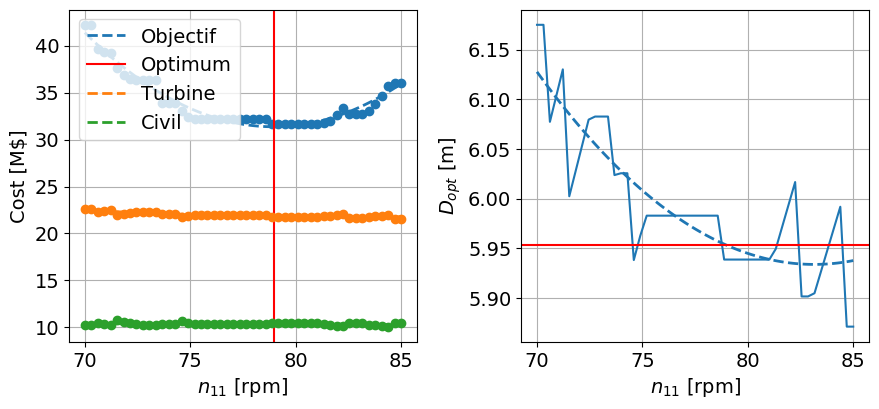

In [39]:
plt.rcParams['font.size']  = 14
plt.rcParams['figure.dpi'] = 100
   
fig,ax = plt.subplots(1,2, figsize=(10,4), sharex=True)
plt.subplots_adjust(hspace=0.02,wspace = 0.3,left = 0.17,right = 0.97,bottom = 0.1,top = 0.93)
ax[0].plot(results_optim.loc[:,'n11'],results_optim.loc[:,'$ optim']/1.0e6,
           linestyle='none',marker='o',color='C0')
xx, yy = p_cost_obj.linspace()
ax[0].plot(xx, yy/1.0e6, lw=2,color='C0',ls='--',label='Objectif')
ax[0].axvline(n11_min_costs,color='red',label='Optimum')
ax[0].plot(results_optim.loc[:,'n11'],results_optim.loc[:,'$ turbine']/1.0e6,
           linestyle='none',marker='o',color='C1')
xx, yy = p_cost_turb.linspace()
ax[0].plot(xx, yy/1.0e6, lw=2,color='C1',ls='--',label='Turbine')
ax[0].plot(results_optim.loc[:,'n11'],results_optim.loc[:,'$ civil']/1.0e6,
           linestyle='none',marker='o',color='C2')
xx, yy = p_cost_civil.linspace()
ax[0].plot(xx, yy/1.0e6, lw=2,color='C2',ls='--',label='Civil')

ax[0].set_xlabel(r'$n_{11}$ [rpm]')
ax[0].set_ylabel(r'Cost [M$]')
ax[0].grid();
ax[0].legend();

ax[1].plot(results_optim.loc[:,'n11'],results_optim.loc[:,'D_opt'])
xx, yy = p_Diam.linspace()
ax[1].plot(xx, yy, lw=2,color='C0',ls='--',label='Objectif')
ax[1].axhline(p_Diam(n11_min_costs), color='red')

ax[1].set_xlabel(r'$n_{11}$ [rpm]')
ax[1].set_ylabel(r'$D_{opt}$ [m]' );
ax[1].grid();

In [46]:
n11_opt = n11_min_costs;
D_opt = p_Diam(n11_min_costs);
print(n11_opt,D_opt)
gain,cost_turbine,n_rpm_sync,d_eta_maj_pm,ponderation,eta_p_weighted = rendement_pondere(colline_modele,n11_opt,D_opt);
geometry_penalty(colline_modele,D_opt,display=True)

78.9517859543371 5.953646218661097
Nombre de poles: 36
eta_M_max = 93.637 %
Re_p = 1.419e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.454 %
Majoration du rendement calculee
d_eta_maj_pm=1.702 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.739 %
Depassement entraxe: 22.32 m 
Depassement hauteur aspirateur: 4.36 m
Depassement decentrement: 2.84 m


3000000.0